* 投球数が多い上位5投手ごとに IOHMM を個別に教師なしで学習・保存

In [ ]:
# 投球数が多い上位5投手ごとに IOHMM を個別に教師なしで学習・保存
import os
import logging
import resource
import pandas as pd
import numpy as np
import pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from IOHMM import SemiSupervisedIOHMM
from IOHMM import CrossEntropyMNL, DiscreteMNL

In [2]:
!pip install IOHMM


Defaulting to user installation because normal site-packages is not writeable


In [3]:
# メモリ・CPU 制限設定

def set_limits(max_mem_mb=None, max_cpu_sec=None):
    if max_mem_mb:
        mb = max_mem_mb * 1024 * 1024
        resource.setrlimit(resource.RLIMIT_AS, (mb, mb))
        logging.info(f"RLIMIT_AS={max_mem_mb}MB")
    if max_cpu_sec:
        resource.setrlimit(resource.RLIMIT_CPU, (max_cpu_sec, max_cpu_sec))
        logging.info(f"RLIMIT_CPU={max_cpu_sec}s")

In [4]:
# smoothing を加えた DiscreteMNL
class SmoothedDiscreteMNL(DiscreteMNL):
    def __init__(self, solver='lbfgs', alpha=1.0, **kw):
        super().__init__(solver=solver, **kw)
        self.alpha = alpha
    def predict_log_proba(self, X):
        logp = super().predict_log_proba(X)
        p    = np.exp(logp)
        p += self.alpha
        p /= p.sum(axis=1, keepdims=True)
        return np.log(p)
    def loglike_per_sample(self, X, y):
        y_idx = y.ravel().astype(int)
        lp    = self.predict_log_proba(X)
        return lp[np.arange(len(y_idx)), y_idx]

In [5]:
import os
import logging
import resource
import pickle
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from IOHMM import UnSupervisedIOHMM  # 変更
from IOHMM import CrossEntropyMNL, DiscreteMNL

def prepare_unsup_states(df_p, test_size=0.2, random_state=42):
    # 前処理は同じ
    req = ['balls','strikes','pitch_type','zone_cluster',
           'pitch_cluster_label','zone','pitcher','game_pk']
    missing = [c for c in req if c not in df_p.columns]
    if missing:
        raise RuntimeError(f"Missing columns: {missing}")

    df = df_p.dropna(subset=['pitch_cluster_label','zone_cluster']).reset_index(drop=True)
    # エンコーダー
    le_zcl = LabelEncoder().fit(df['zone_cluster'])
    le_z   = LabelEncoder().fit(df['zone'])
    le_pcl = LabelEncoder().fit(df["pitch_cluster_label"])
    # 変換
    df['zone_cluster'] = le_zcl.transform(df['zone_cluster'])
    df['zone']         = le_z.transform(df['zone'])
    df["pitch_cluster_label"] = le_pcl.transform(df["pitch_cluster_label"])
    df['state_id']     = df['zone']
    num_states = df['state_id'].nunique()

    seqs = {
        f"{p}_game_{g}": gdf.reset_index(drop=True)
        for (p, g), gdf in df.groupby(['pitcher','game_pk'])
        if len(gdf) >= 2
    }

    # train/test split
    keys = list(seqs.keys())
    train_keys, test_keys = train_test_split(keys,
                                             test_size=test_size,
                                             random_state=random_state)

    dfs_train = []
    for k in train_keys:
        s = seqs[k]
        dfs_train.append([s, {}])  # 空辞書＝完全非教師あり

    test_df = pd.concat([seqs[k] for k in test_keys], ignore_index=True)
    return dfs_train, num_states, test_df, le_zcl, le_z, le_pcl


In [6]:
def build_and_train_unsup(dfs_train, num_states, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    shmm = UnSupervisedIOHMM(num_states=num_states)
    shmm.set_models(
        model_emissions=[SmoothedDiscreteMNL(solver='lbfgs'), SmoothedDiscreteMNL(solver='lbfgs')],
        model_transition=CrossEntropyMNL(solver='lbfgs'),
        model_initial=   CrossEntropyMNL(solver='lbfgs')
    )
    covs = ['balls','strikes']
    shmm.set_inputs(
        covariates_initial=covs,
        covariates_transition=covs,
        covariates_emissions=[covs, covs]
    )
    shmm.set_outputs([['pitch_cluster_label'], ['zone_cluster']])
    seqs_only = [df for df, _ in dfs_train]   # DataFrame のみのリスト
    shmm.set_data(seqs_only)
    shmm.train()
    with open(os.path.join(save_dir, 'unsup6_model.pkl'), 'wb') as f:
        pickle.dump(shmm, f)
    logging.info(f"Saved unsupervised model to {save_dir}/unsup6_model.pkl | "
                 f"LogLikelihood={shmm.log_likelihood:.4f}")


In [7]:
# メイン処理
if __name__ == '__main__':
    logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s %(message)s')
    set_limits(max_mem_mb=32000)
    # 全体データ読み込み
    df_all = pd.read_csv('df_clean_zone_cluster.csv')
    # 投球数上位5投手を抽出
    top5 = df_all['pitcher'].value_counts().nlargest(5).index.tolist()
    logging.info(f"Top5 pitchers: {top5}")
    # 各投手ごとにモデル学習 & テストデータ・エンコーダー保存
    for pitcher in top5:
        logging.info(f"=== Processing pitcher: {pitcher} ===")
        df_p = df_all[df_all['pitcher'] == pitcher].copy()
        # 前処理 & split
        dfs_train, num_states, test_df, le_zcl, le_z,le_pcl = prepare_unsup_states(df_p)
        # 出力先ディレクトリ
        out_dir = f'iohmm_{pitcher}'
        os.makedirs(out_dir, exist_ok=True)
        # テストデータを CSV に保存
        test_df.to_csv(os.path.join(out_dir, 'un6_test_data.csv'), index=False)
        logging.info(f"Saved test data to {out_dir}/un6_test_data.csv")
        # エンコーダーを pickle で保存
        with open(os.path.join(out_dir, 'un6_encoders.pkl'), 'wb') as f:
            pickle.dump({
                'le_zone_cluster': le_zcl,
                'le_zone': le_z,
                'le_pitch_cluster_label': le_pcl
            }, f)
        logging.info(f"Saved encoders to {out_dir}/un6_encoders.pkl")
        # モデル構築 & 学習
        hidden_states=6
        build_and_train_unsup(dfs_train, hidden_states, save_dir=out_dir)

2025-05-26 11:28:52,136 INFO RLIMIT_AS=32000MB
2025-05-26 11:29:28,023 INFO Top5 pitchers: [605400, 554430, 656302, 543037, 621244]
2025-05-26 11:29:28,030 INFO === Processing pitcher: 605400 ===
2025-05-26 11:29:28,505 INFO Saved test data to iohmm_605400/un6_test_data.csv
2025-05-26 11:29:28,507 INFO Saved encoders to iohmm_605400/un6_encoders.pkl
2025-05-26 11:29:33,078 INFO log likelihood of iteration 0: -36178.8988
2025-05-26 11:29:36,504 INFO log likelihood of iteration 1: -36183.1619
2025-05-26 11:29:40,698 INFO log likelihood of iteration 2: -36183.0050
2025-05-26 11:29:46,329 INFO log likelihood of iteration 3: -36183.0518
2025-05-26 11:29:49,589 INFO log likelihood of iteration 4: -36183.0648
2025-05-26 11:29:52,899 INFO log likelihood of iteration 5: -36183.0746
2025-05-26 11:29:56,609 INFO log likelihood of iteration 6: -36183.1459
2025-05-26 11:29:59,897 INFO log likelihood of iteration 7: -36183.1513
2025-05-26 11:30:03,261 INFO log likelihood of iteration 8: -36183.1536


[[0.16639178 0.1671037  0.16644843 0.16653551 0.16651676 0.16700384]
 [0.1667108  0.16678156 0.16614532 0.16663927 0.16670869 0.16701436]
 [0.16661168 0.16696409 0.16601279 0.16631221 0.16698442 0.1671148 ]
 [0.166899   0.16645679 0.16704961 0.16647082 0.16676017 0.16636361]
 [0.16682479 0.16654342 0.16684718 0.16700772 0.16635861 0.16641829]
 [0.16684379 0.16678745 0.16624607 0.16678956 0.16682826 0.16650487]]
[[0.16610207 0.16784817 0.16604391 0.16629907 0.16622525 0.16748154]
 [0.1668376  0.16703948 0.16537327 0.16657605 0.16669136 0.16748224]
 [0.16659432 0.16744713 0.16501228 0.16582068 0.16742255 0.16770306]
 [0.16737877 0.16615412 0.16771746 0.1661272  0.16681213 0.16581031]
 [0.16728169 0.16634685 0.16709749 0.16743417 0.1658217  0.16601809]
 [0.16757637 0.16693875 0.16536213 0.16706387 0.16688893 0.16616996]]
[[0.1658117  0.16859478 0.1656392  0.1660618  0.16593308 0.16795943]
 [0.16696359 0.16729689 0.16460391 0.16651195 0.16667314 0.16795053]
 [0.16657494 0.16792952 0.164015

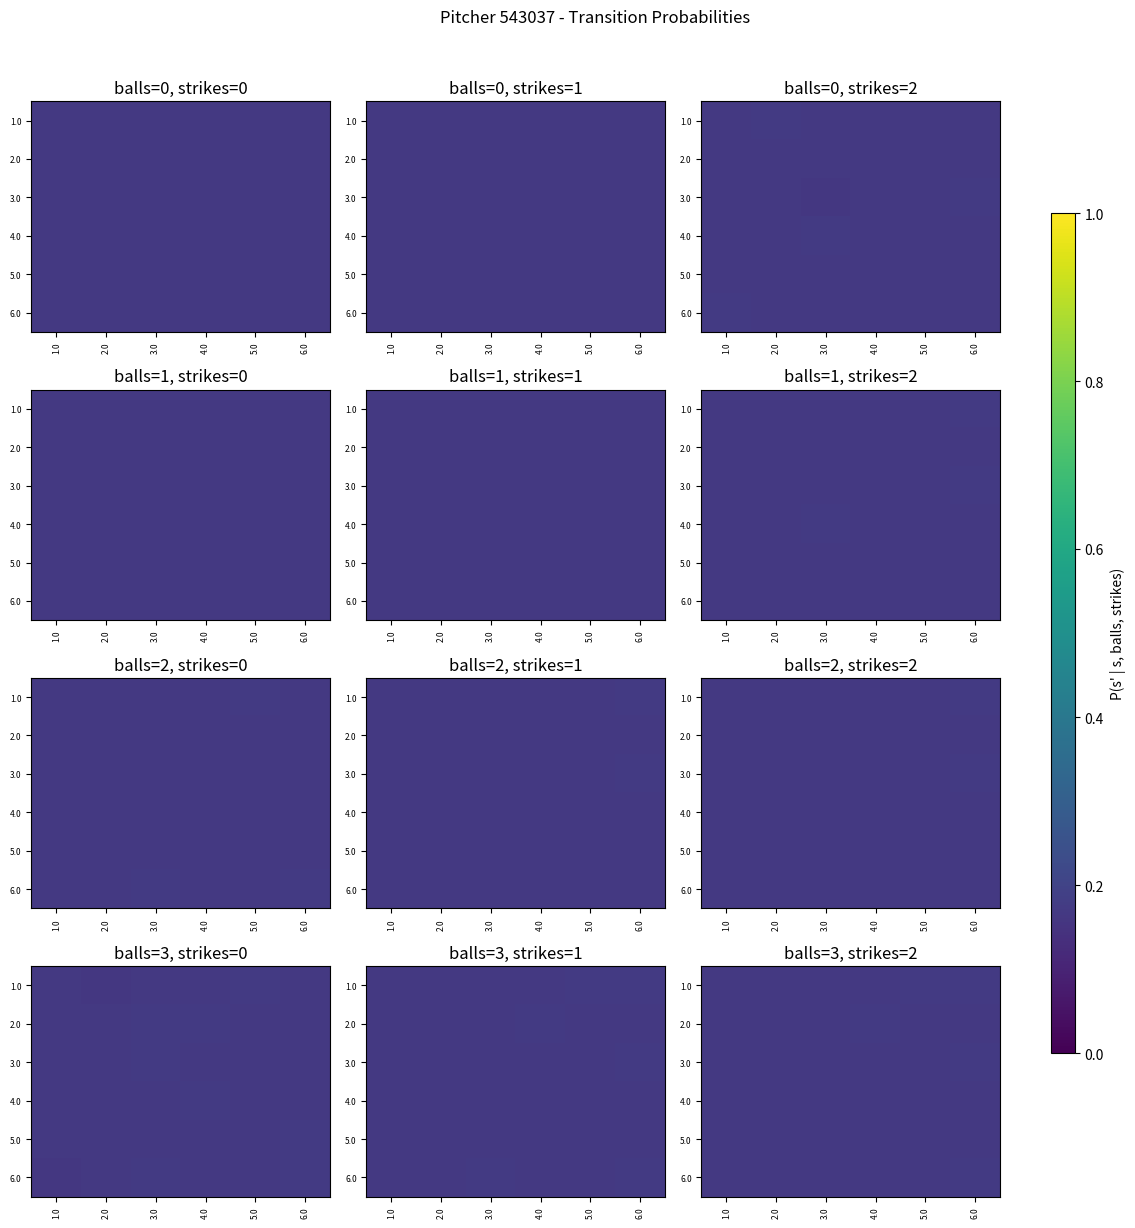

[[0.16686786 0.16755683 0.16622187 0.16768    0.16573702 0.16593642]
 [0.1662006  0.1673154  0.16659213 0.16700708 0.16616659 0.1667182 ]
 [0.16674391 0.16667095 0.16642865 0.16659082 0.16670387 0.1668618 ]
 [0.1666139  0.16621823 0.16645519 0.16634221 0.16744734 0.16692313]
 [0.16715306 0.16599242 0.16685665 0.1673373  0.16610139 0.16655919]
 [0.16658331 0.16703848 0.16552915 0.16781211 0.16566303 0.16737391]]
[[0.16780429 0.1666583  0.16628504 0.16671383 0.16564864 0.1668899 ]
 [0.16628749 0.16644347 0.16630282 0.16674736 0.16740893 0.16680993]
 [0.16763198 0.16677858 0.16585322 0.16647742 0.16600512 0.16725368]
 [0.1677144  0.16586449 0.16660821 0.16604964 0.1677439  0.16601937]
 [0.16842187 0.16569372 0.16700292 0.16733172 0.16650372 0.16504605]
 [0.16630638 0.16711584 0.16661109 0.1670917  0.16650657 0.16636843]]
[[0.16874241 0.16576108 0.16634471 0.16574971 0.1655568  0.16784529]
 [0.16637195 0.16557363 0.16601154 0.16648557 0.16865807 0.16689924]
 [0.16852297 0.1668845  0.165278

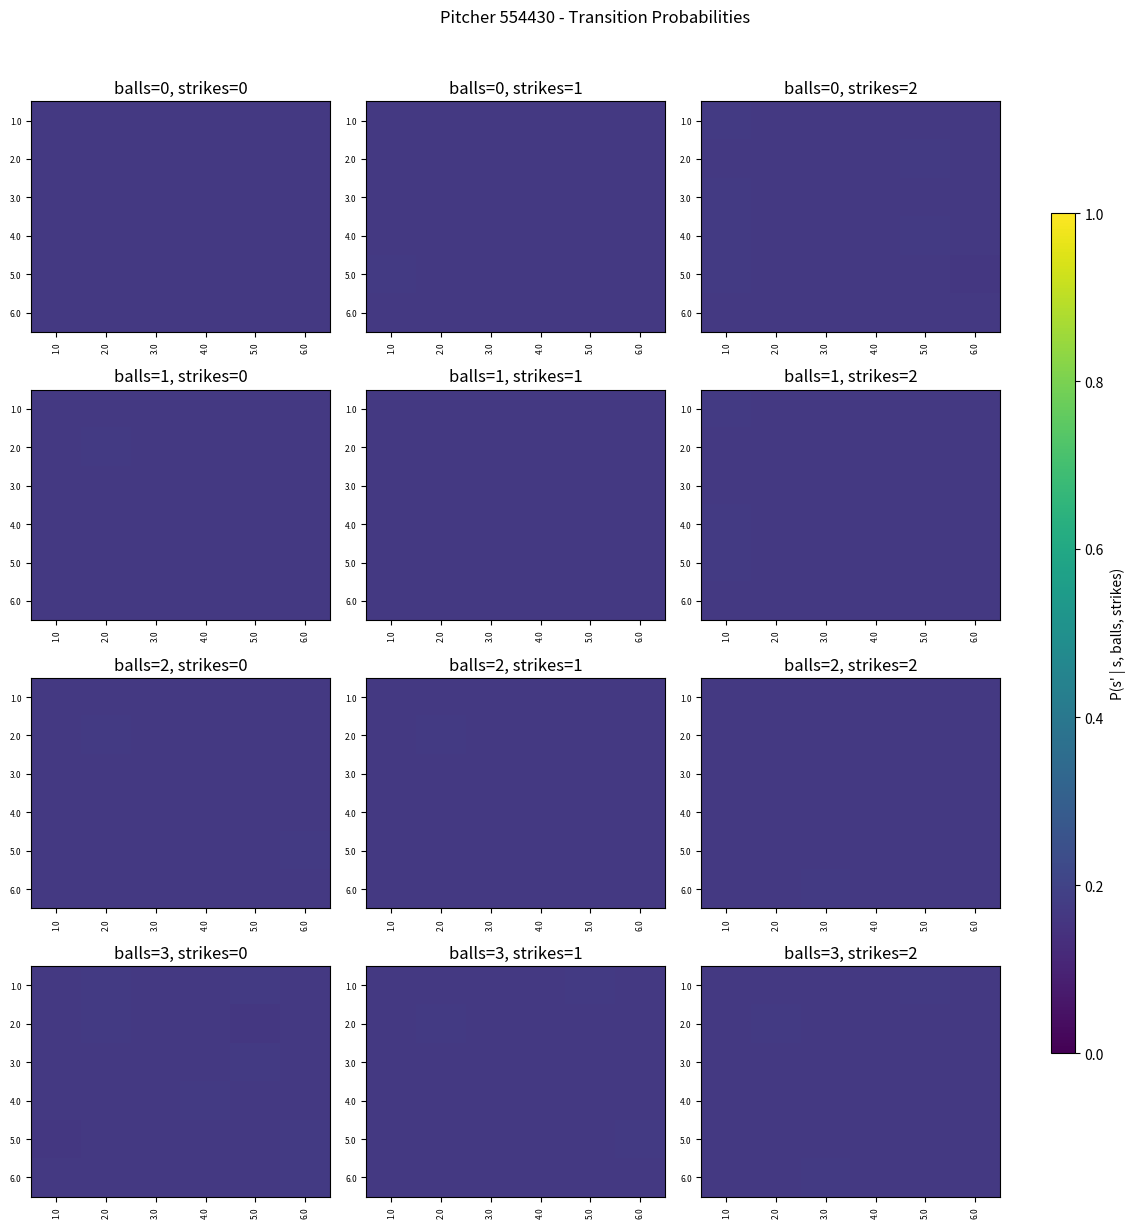

[[0.1667761  0.16644714 0.16679212 0.16666548 0.16663923 0.16667993]
 [0.16625484 0.16598974 0.16676348 0.16678473 0.16703166 0.16717554]
 [0.16666254 0.16635451 0.16722336 0.16636181 0.16679109 0.16660668]
 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.16691603 0.16586003 0.16708572 0.166018   0.16706074 0.16705947]
 [0.16639241 0.16555977 0.16727151 0.16620734 0.16719811 0.16737086]]
[[0.16692272 0.16616931 0.16695429 0.1666651  0.16659619 0.16669239]
 [0.16554335 0.16525397 0.16673251 0.16704942 0.16749511 0.16792563]
 [0.16665503 0.16596834 0.16796168 0.16595485 0.16694545 0.16651466]
 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.16735134 0.16487884 0.16762348 0.16495848 0.16757978 0.16760808]
 [0.16583898 0.164149   0.16814011 0.1654635  0.16795222 0.16845618]]
[[0.16706935 0.16589181 0.16711648 0.16666459 0.16655304 0.16670472]
 [0.16483303 0.16451959 0.16669965 0.16731263 0.16795793 0.16867716]
 [0.16664662 0.16558219 0.168702

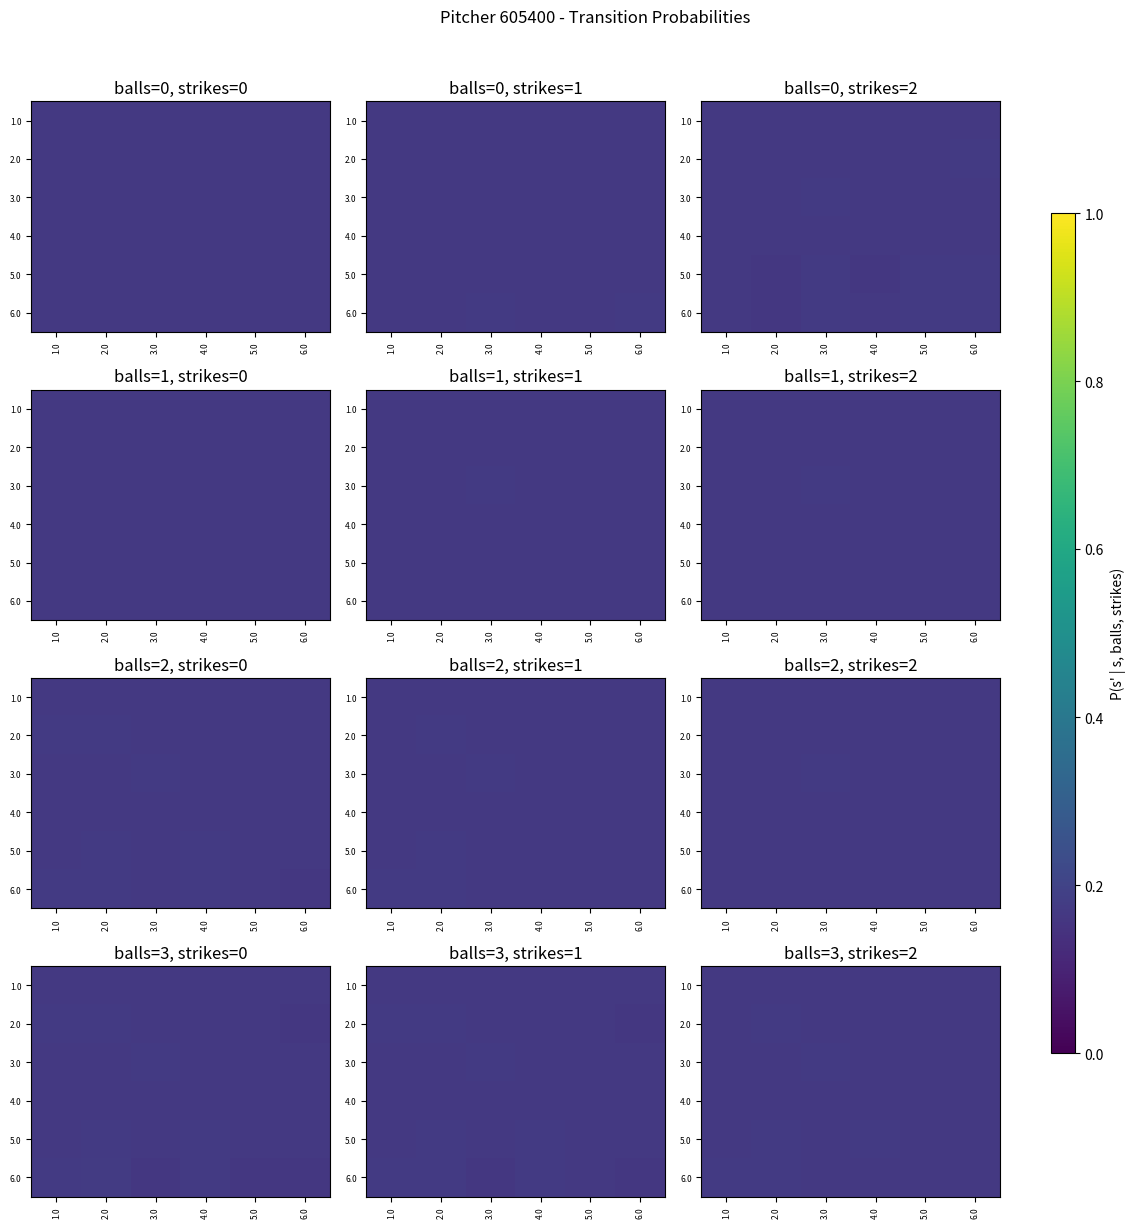

[[0.16635188 0.16707868 0.16658747 0.16663161 0.16687546 0.1664749 ]
 [0.16703216 0.16625847 0.16622124 0.1670565  0.16692739 0.16650424]
 [0.16748063 0.1661468  0.1668347  0.16652939 0.16644264 0.16656584]
 [0.16637445 0.16625406 0.16714105 0.16706152 0.16646739 0.16670155]
 [0.16587579 0.1665507  0.16700947 0.16683005 0.16657923 0.16715477]
 [0.16703968 0.16599327 0.16659863 0.16618887 0.16727232 0.16690724]]
[[0.16594129 0.1676211  0.16646509 0.16659043 0.16715541 0.16622667]
 [0.16739249 0.1657717  0.16553154 0.16767566 0.16727077 0.16635783]
 [0.16839953 0.16545406 0.16697046 0.16643642 0.16624352 0.166496  ]
 [0.16571233 0.16557914 0.16772238 0.16797601 0.16625098 0.16675916]
 [0.16424588 0.16649257 0.16737757 0.16726029 0.16661754 0.16800614]
 [0.16751768 0.16513134 0.16649926 0.16557511 0.16806055 0.16721605]]
[[0.1655311  0.16816466 0.16634219 0.16654865 0.1674352  0.1659782 ]
 [0.16775223 0.165285   0.16484336 0.16829574 0.16761349 0.16621018]
 [0.16932206 0.16476284 0.167104

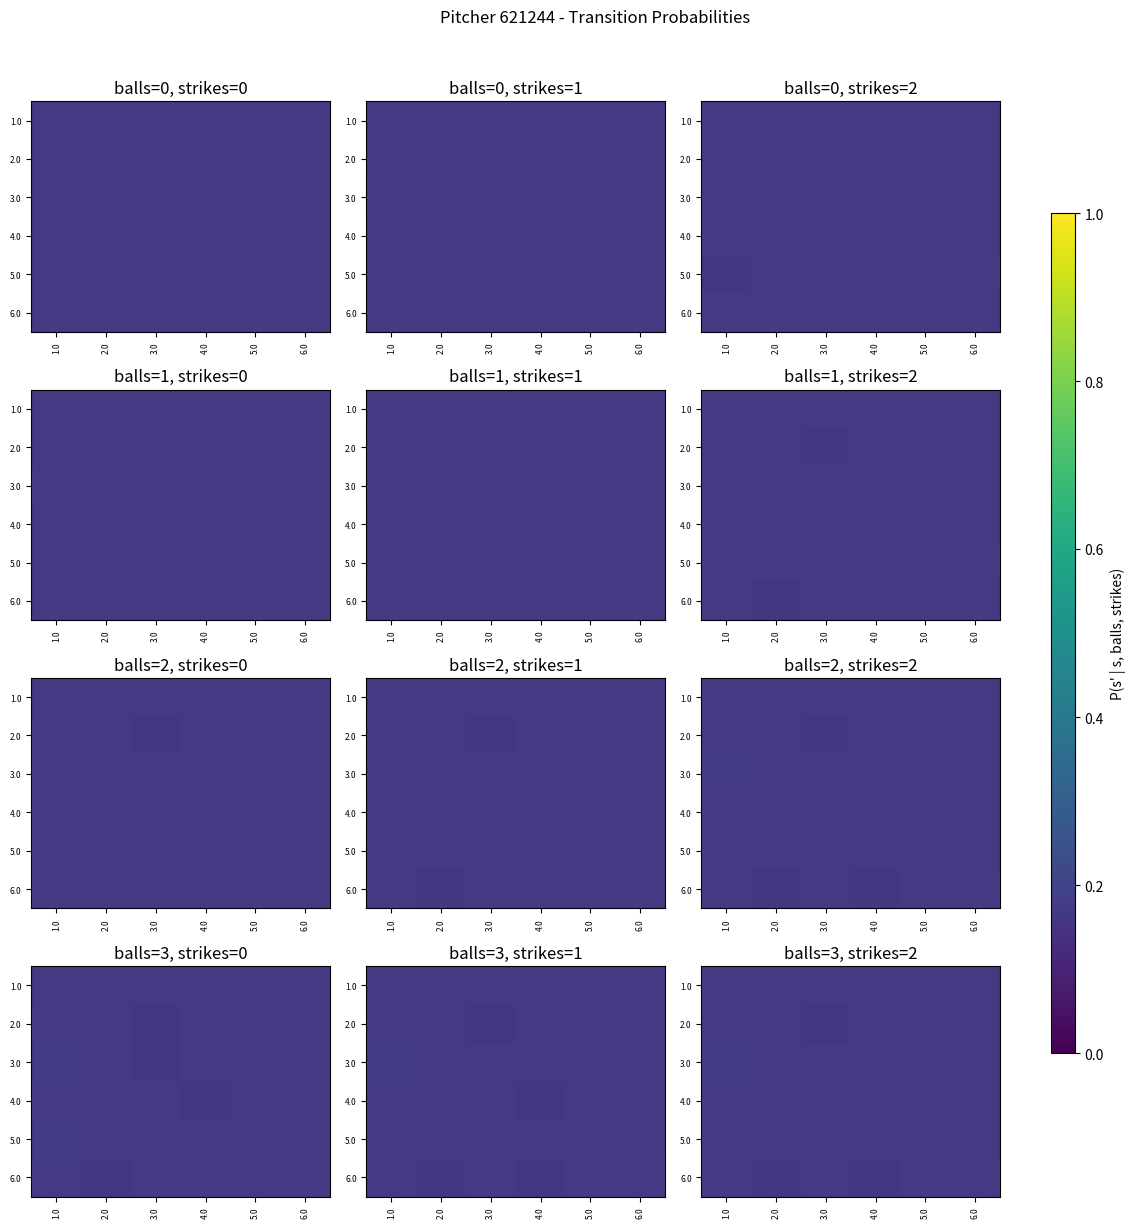

[[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.1667212  0.16663538 0.16674199 0.16656517 0.16659712 0.16673912]
 [0.16624777 0.16655    0.16661229 0.16743759 0.16696079 0.16619156]
 [0.16640022 0.16670319 0.16710943 0.1668966  0.16648478 0.16640577]
 [0.16481793 0.16708694 0.16613216 0.16789657 0.16694485 0.16712154]
 [0.16668527 0.16667534 0.16666409 0.16665569 0.16665092 0.1666687 ]]
[[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.16679542 0.16659281 0.16683989 0.16642627 0.16650473 0.16684088]
 [0.16540279 0.16630802 0.16628821 0.168997   0.16764135 0.16536262]
 [0.16586248 0.16679285 0.16801539 0.16720052 0.16611454 0.16601423]
 [0.1609488  0.16801609 0.16450188 0.17050686 0.16801935 0.16800702]
 [0.1667115  0.16668617 0.16665814 0.16663767 0.16663029 0.16667623]]
[[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.16686962 0.1665502  0.16693778 0.16628743 0.16641233 0.16694264]
 [0.16455771 0.16606196 0.165960

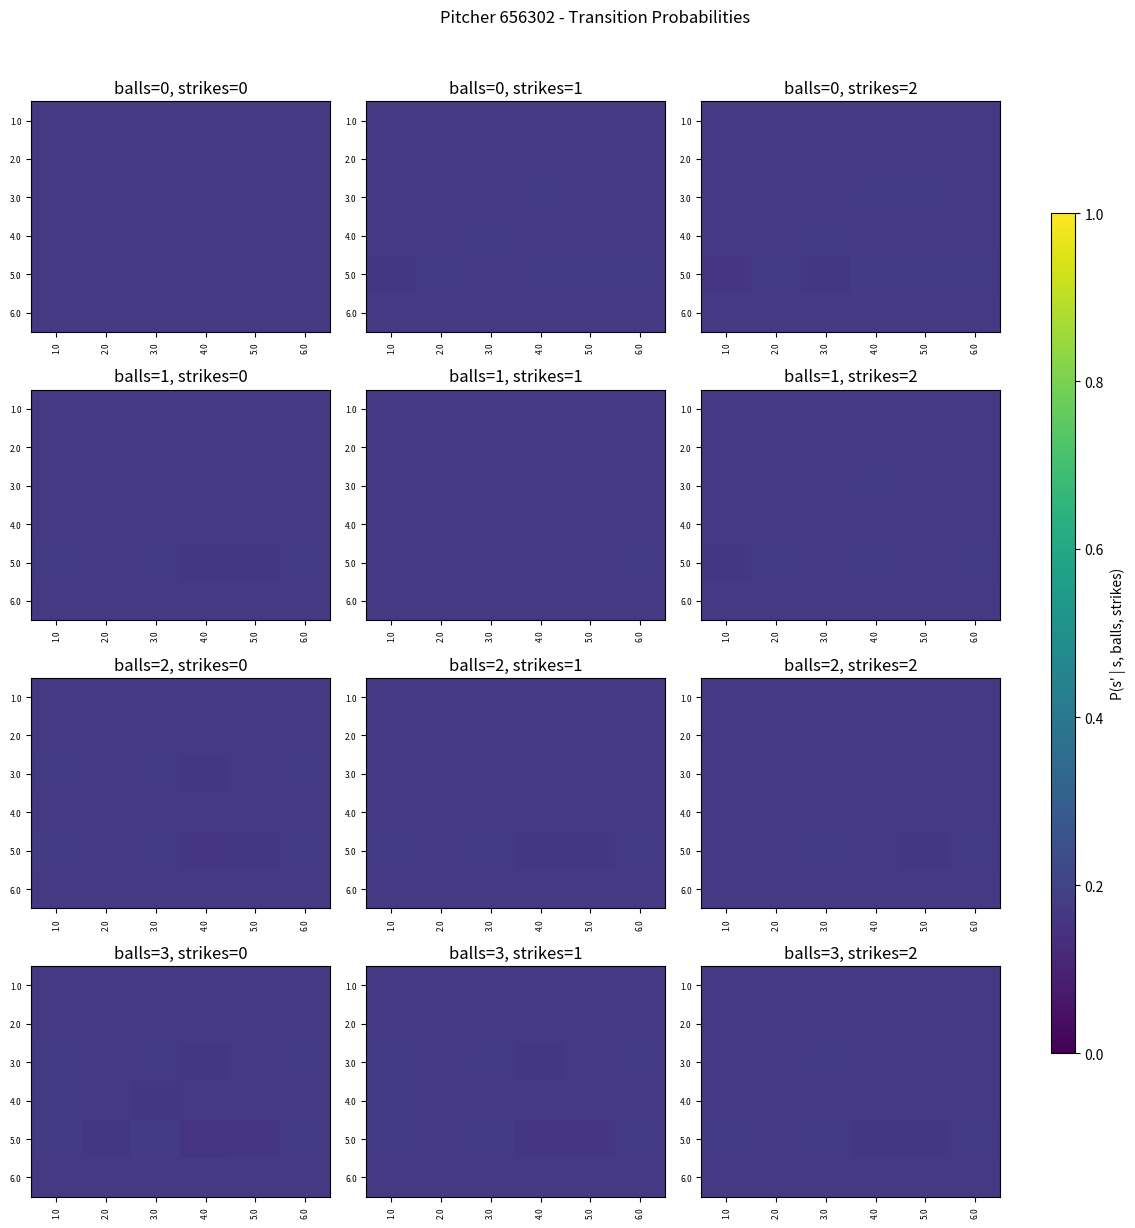

In [ ]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# 投手リスト
pitch_list = ["543037", "554430", "605400", "621244", "656302"]
covs = [(b, s) for b in range(4) for s in range(3)]  # balls-strikes パターン

for pitch in pitch_list:
    model_dir = f"iohmm_{pitch}"
    # モデルファイル探索
    for fname in ("unsup6_model.pkl"):
        model_fp = os.path.join(model_dir, "unsup6_model.pkl")
    if not os.path.isfile(model_fp):
        print(f"[{pitch}] モデルファイルが見つかりません ({model_fp})")
        continue

    enc_fp = os.path.join(model_dir, "un6_encoders.pkl")
    if not os.path.exists(enc_fp):
        print(f"[{pitch}] エンコーダーファイルが見つかりません: {enc_fp}")
        continue

    # モデルとエンコーダ読み込み
    with open(model_fp, "rb") as mf:
        shmm_loaded = pickle.load(mf)
    with open(enc_fp, "rb") as ef:
        encs = pickle.load(ef)
    le_z = encs["le_zone"]  # 隠れ状態のラベルエンコーダ

    n_states     = shmm_loaded.num_states
    state_ids    = np.arange(n_states)
    state_labels = le_z.inverse_transform(state_ids)

    # グリッド Plot
    fig, axes = plt.subplots(4, 3, figsize=(12, 12))
    fig.suptitle(f"Pitcher {pitch} - Transition Probabilities", y=1.02)

    for idx, (b, s) in enumerate(covs):
        ax = axes.flat[idx]
        # 前状態 s_t からの遷移確率行列を構築
        trans_mat = np.vstack([
            np.exp(shmm_loaded.model_transition[st]
                   .predict_log_proba(np.array([[b, s]])))[0]
            for st in range(n_states)
        ])
        print(trans_mat)
        im = ax.imshow(trans_mat, vmin=0, vmax=1,
                       aspect='auto', cmap=cm.viridis)
        
        ax.set_title(f"balls={b}, strikes={s}")
        ax.set_xticks(range(n_states))
        ax.set_yticks(range(n_states))
        ax.set_xticklabels(state_labels, rotation=90, fontsize=6)
        ax.set_yticklabels(state_labels,           fontsize=6)

    # 全体カラーバー
    cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax, label="P(s' | s, balls, strikes)")
    plt.tight_layout(rect=[0,0,0.85,1.0])
    plt.show()


In [17]:
import matplotlib.font_manager as fm

# 日本語対応フォント候補を抽出して表示
for font in fm.findSystemFonts(fontpaths=None, fontext='ttf'):
    if any(x in font.lower() for x in ['gothic', 'meiryo', 'noto', 'ipa', 'takao']):
        print(font)


/usr/share/fonts/opentype/noto/NotoSerifCJK-Bold.ttc
/usr/share/fonts/opentype/noto/NotoSansCJK-Light.ttc
/usr/share/fonts/meiryo/meiryo.ttc
/usr/share/fonts/opentype/ipafont-gothic/ipagp.ttf
/usr/share/fonts/opentype/urw-base35/URWGothic-Demi.otf
/usr/share/fonts/truetype/fonts-japanese-gothic.ttf
/usr/share/fonts/opentype/ipafont-gothic/ipag.ttf
/usr/share/fonts/truetype/takao-mincho/TakaoMincho.ttf
/usr/share/fonts/opentype/noto/NotoSansCJK-Bold.ttc
/usr/share/fonts/truetype/noto/NotoSansMono-Regular.ttf
/usr/share/fonts/opentype/noto/NotoSansCJK-Black.ttc
/usr/share/fonts/opentype/urw-base35/URWGothic-Book.otf
/usr/share/fonts/opentype/noto/NotoSerifCJK-Medium.ttc
/usr/share/fonts/opentype/noto/NotoSansCJK-Medium.ttc
/usr/share/fonts/truetype/takao-gothic/TakaoGothic.ttf
/usr/share/fonts/truetype/takao-mincho/TakaoPMincho.ttf
/usr/share/fonts/opentype/ipafont-mincho/ipam.ttf
/usr/share/fonts/opentype/noto/NotoSerifCJK-Light.ttc
/usr/share/fonts/meiryo/meiryob.ttc
/usr/share/fonts/t

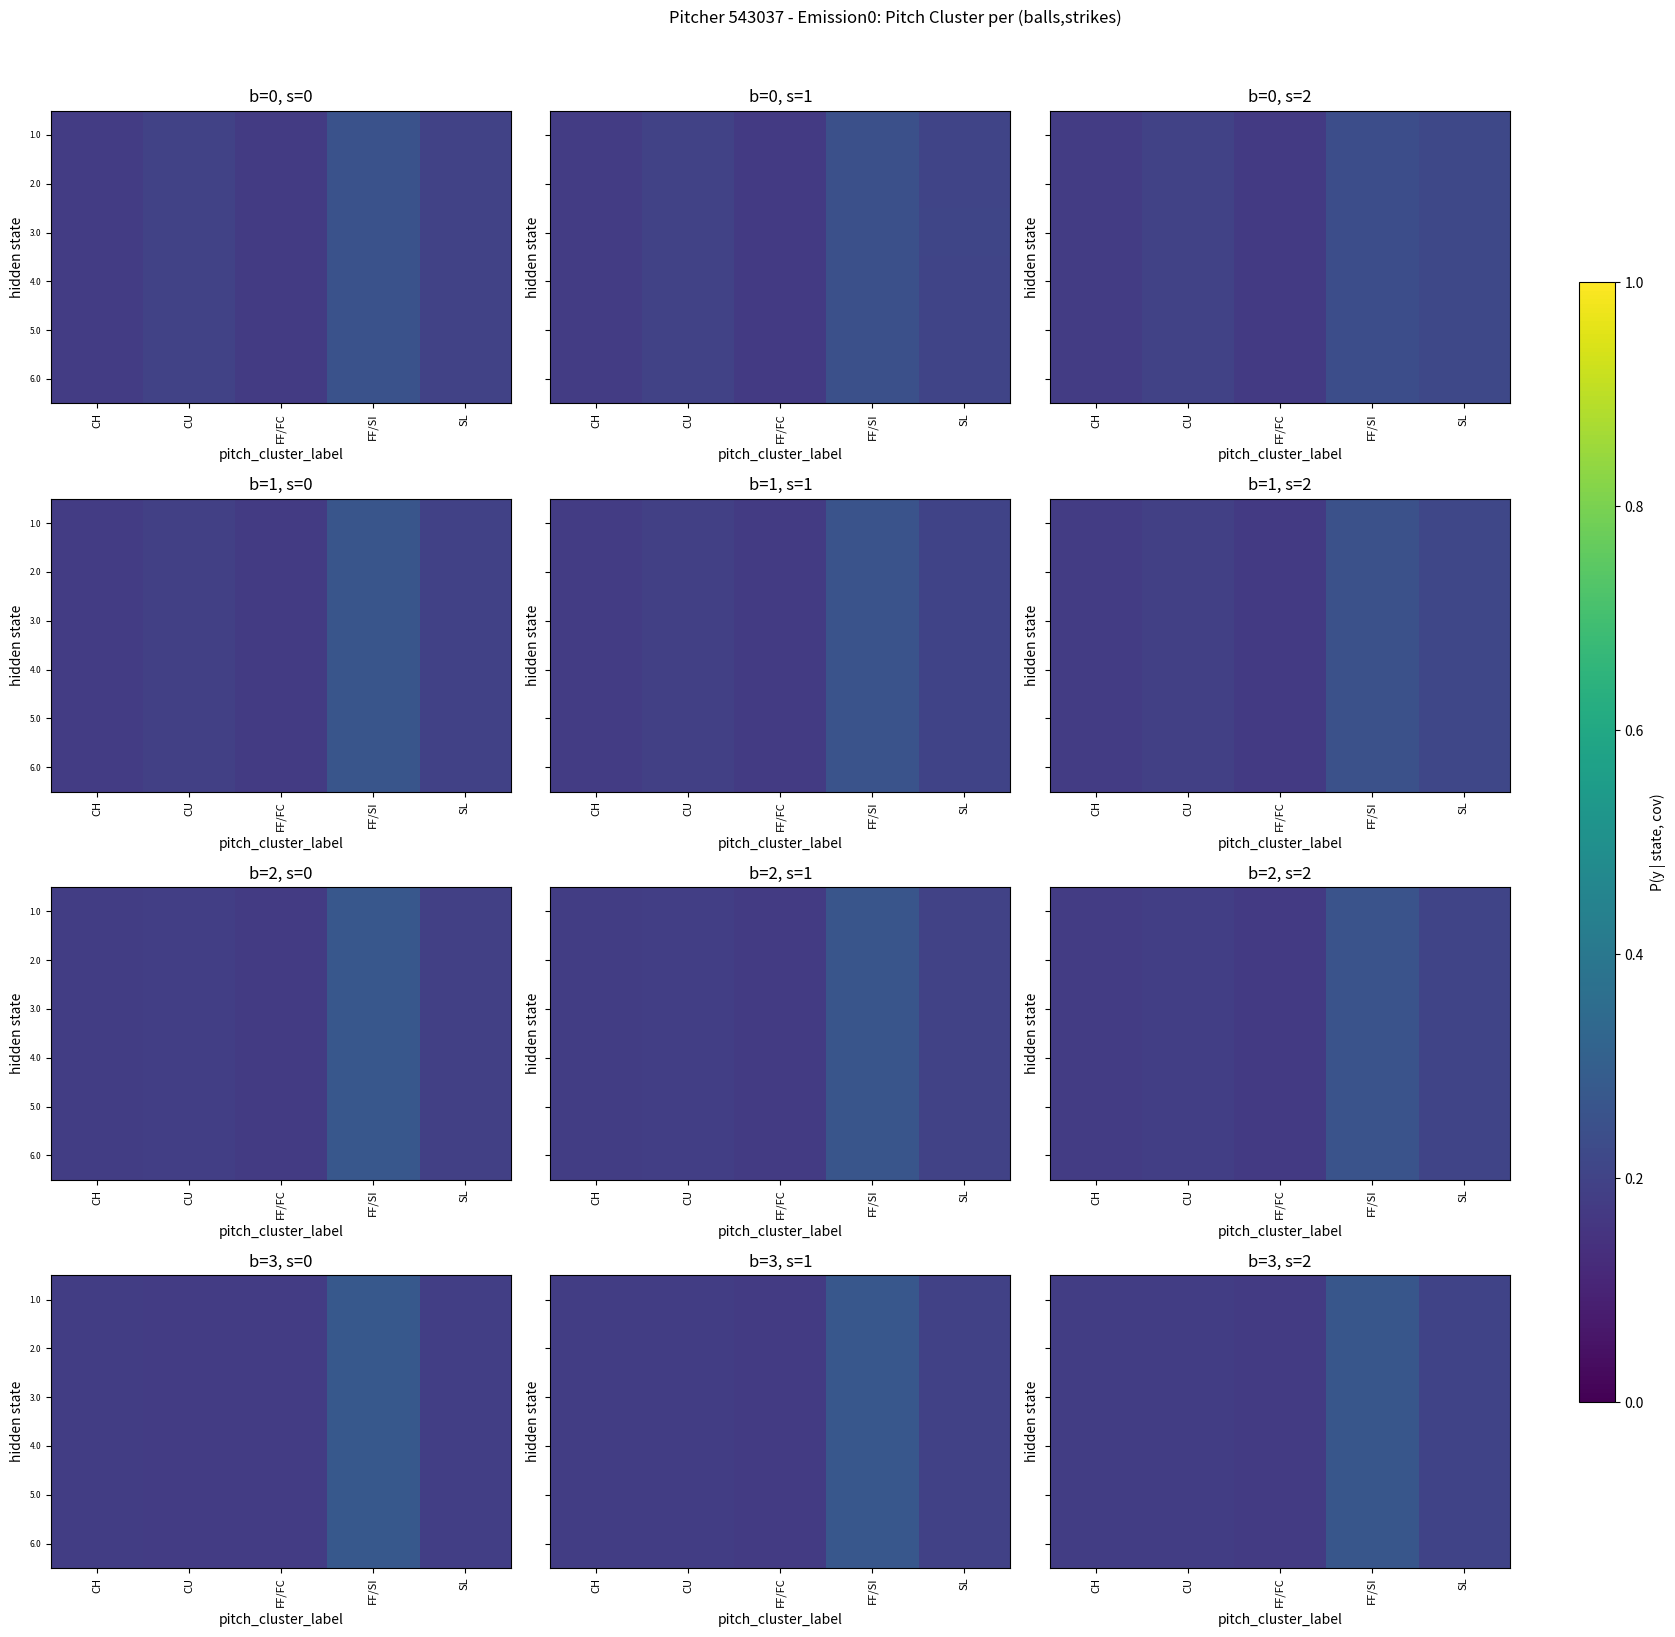

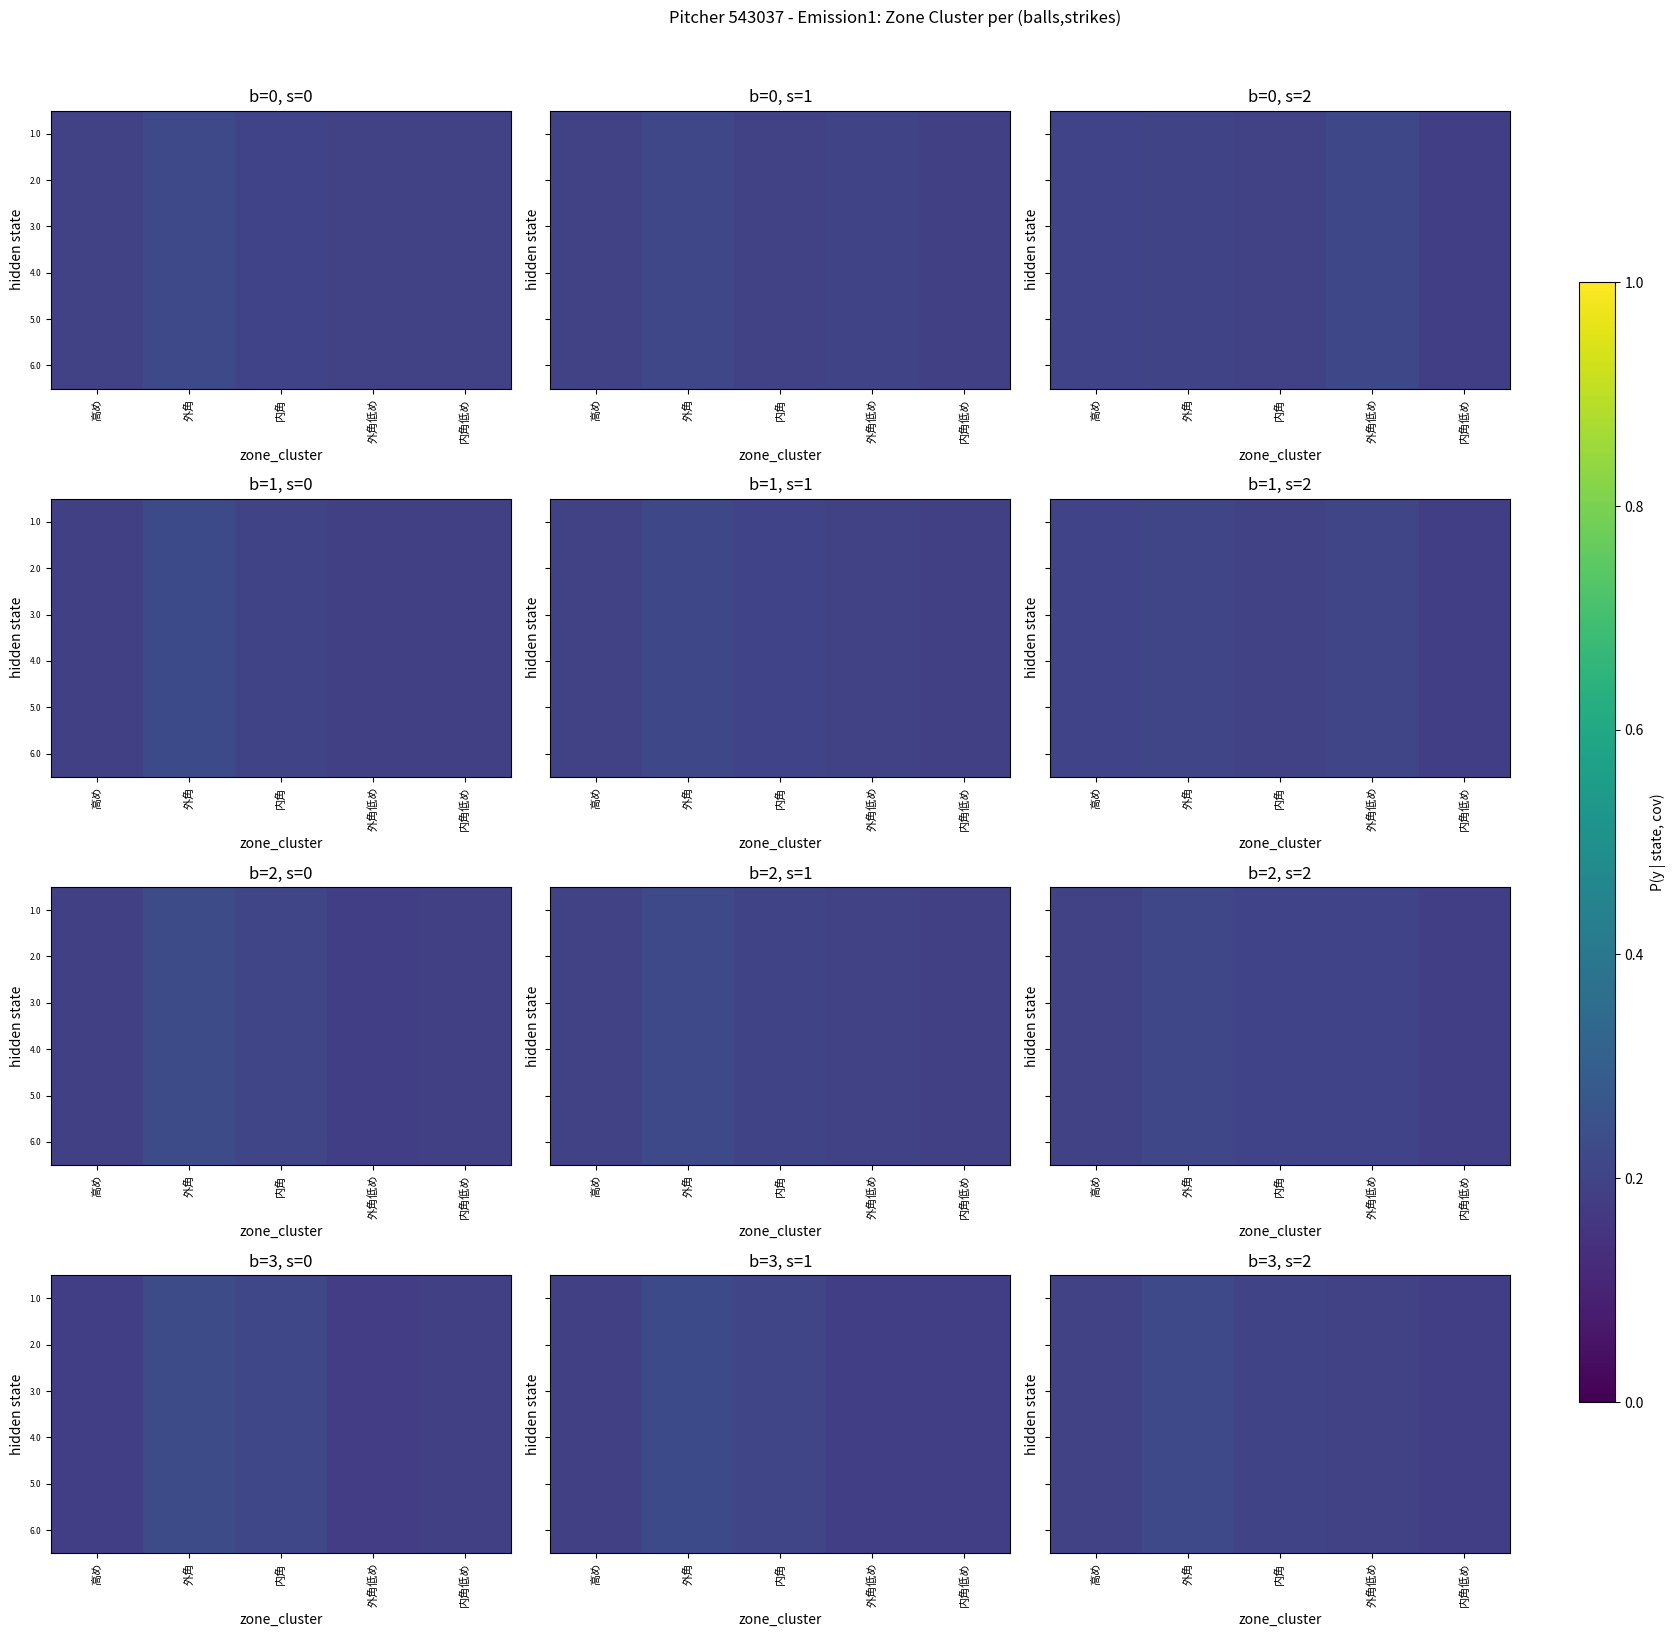

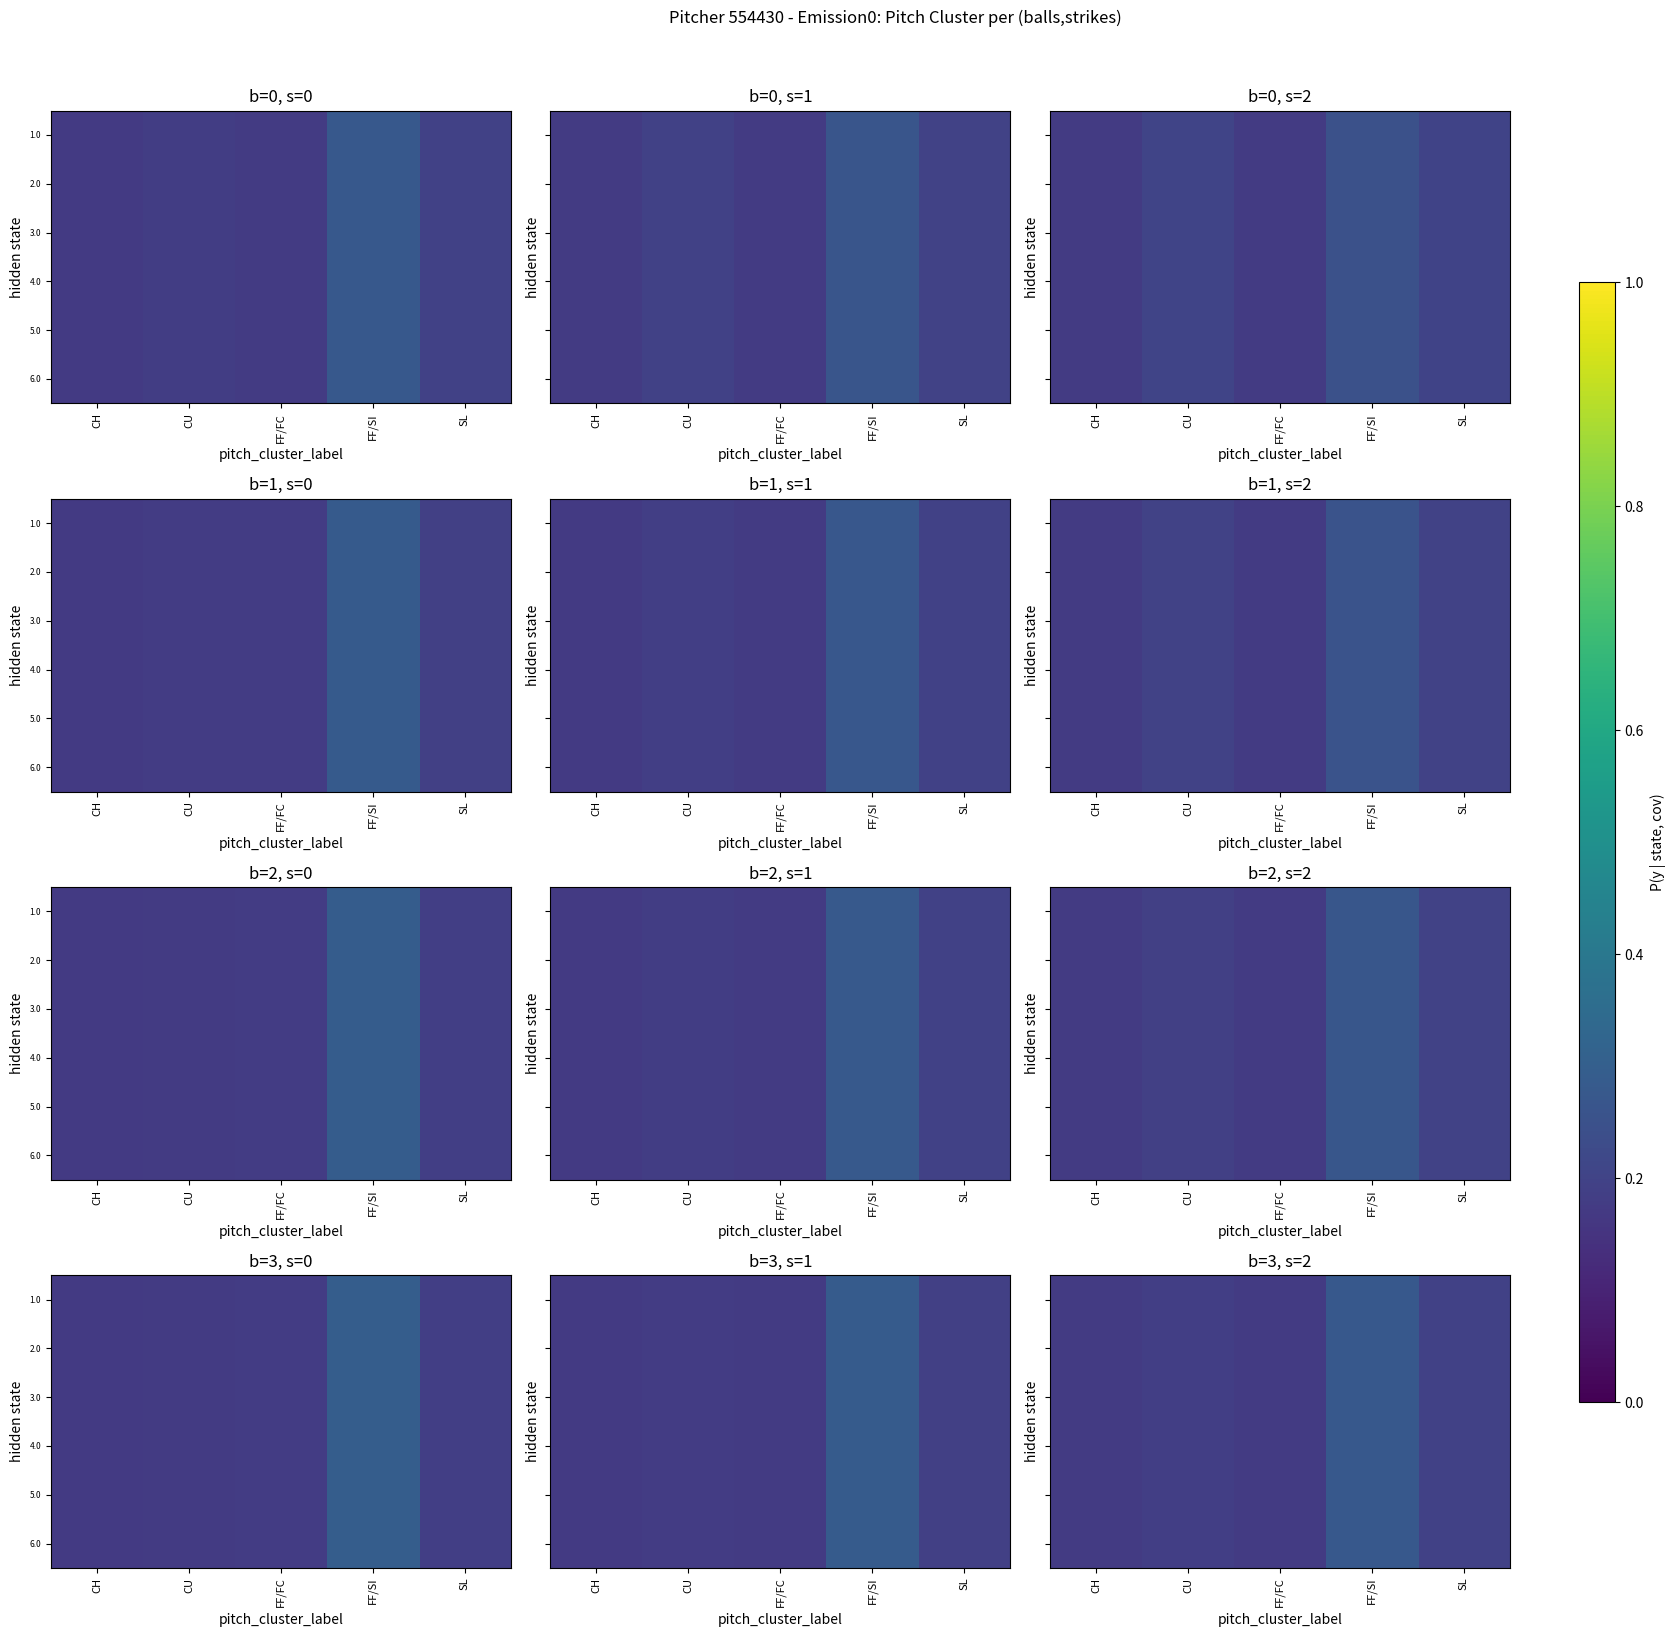

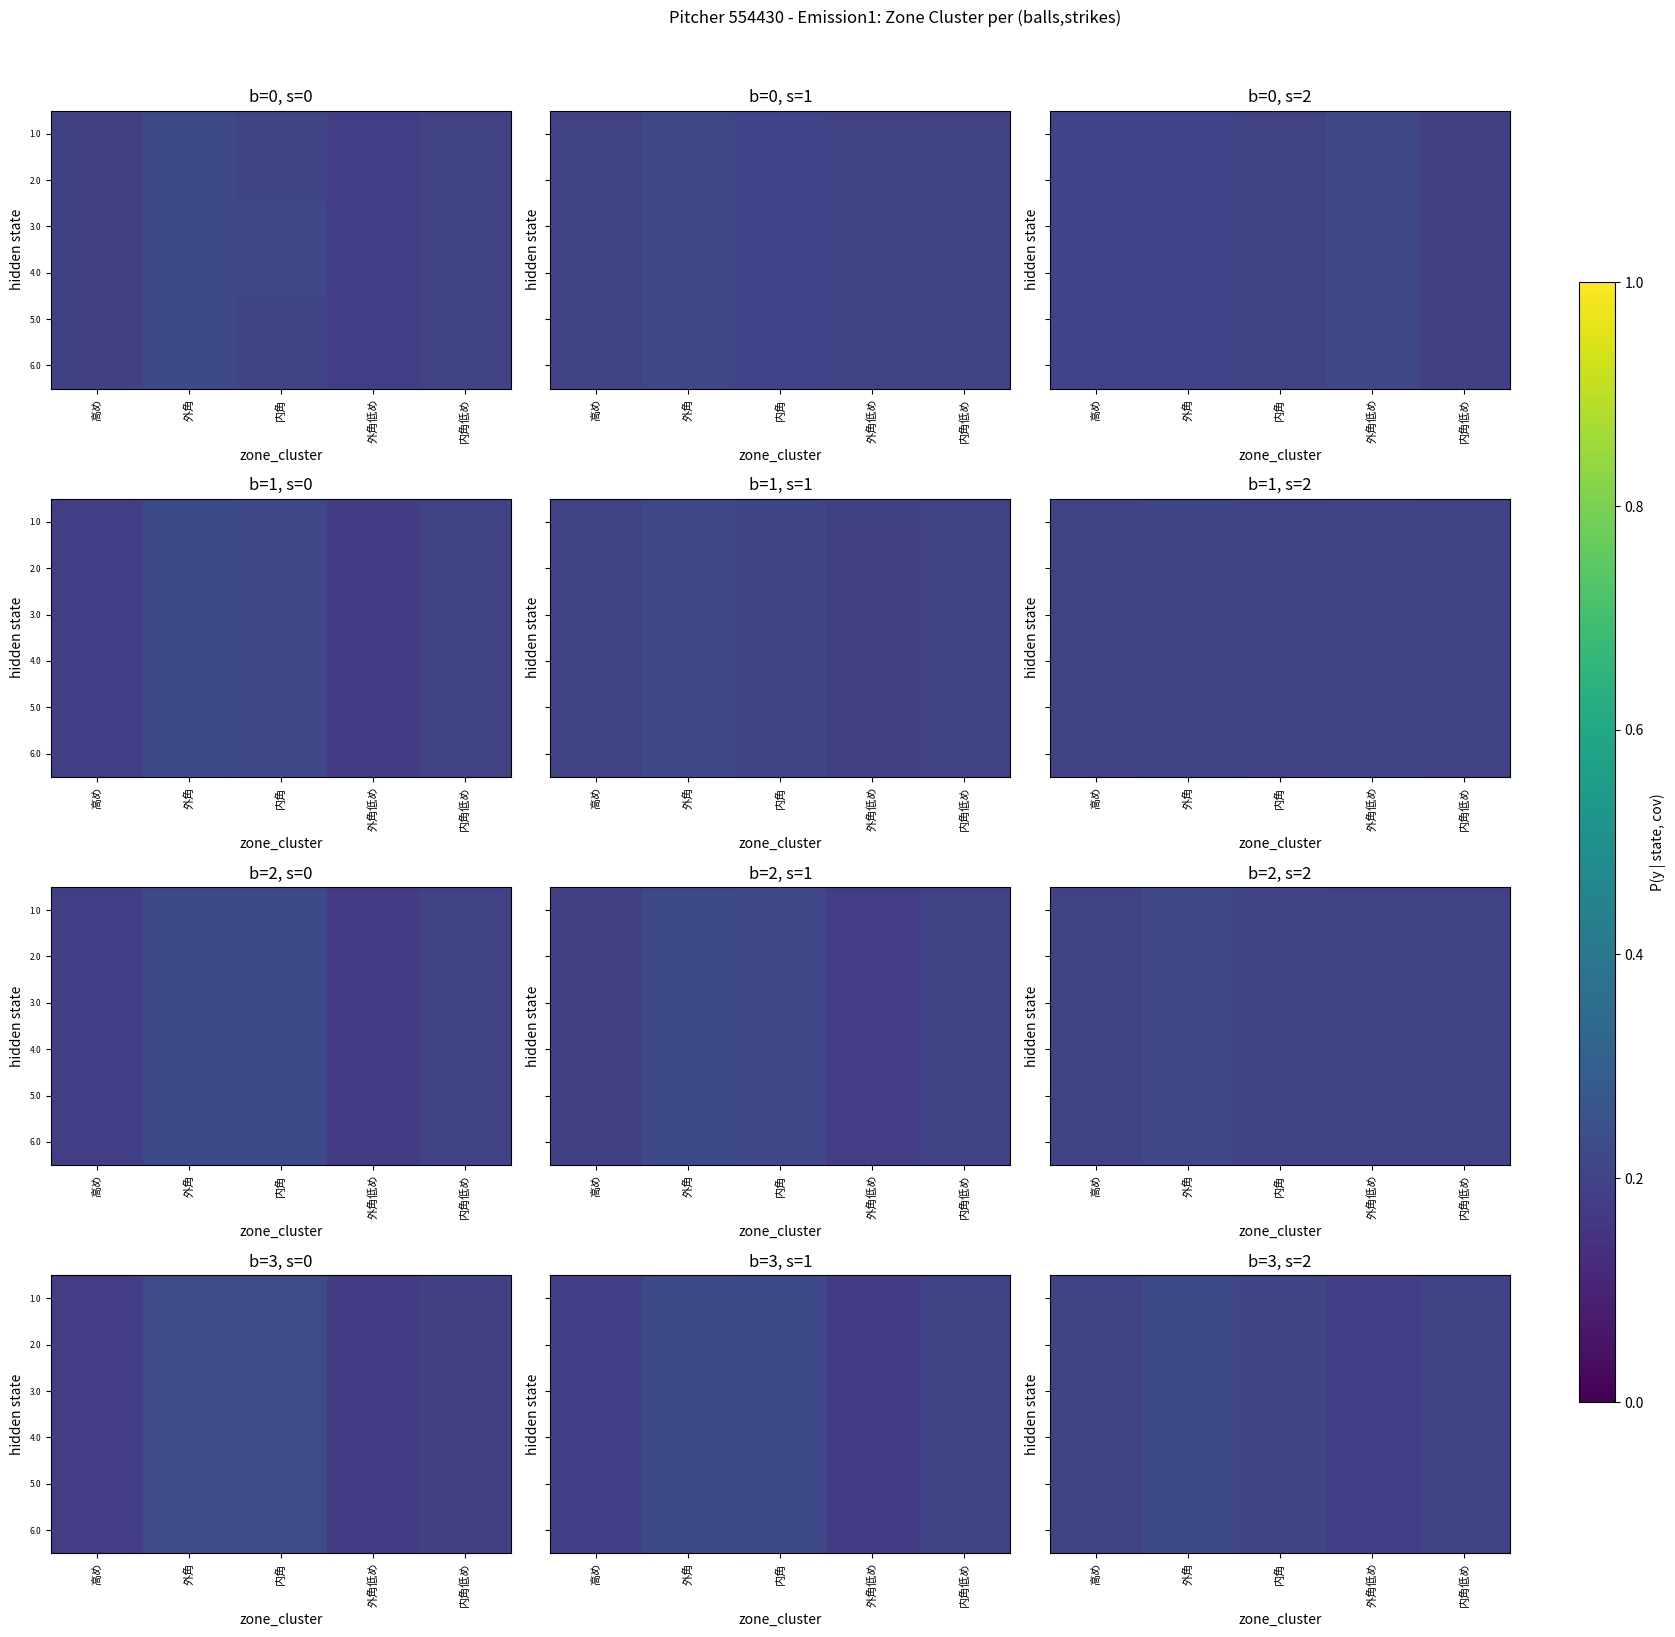

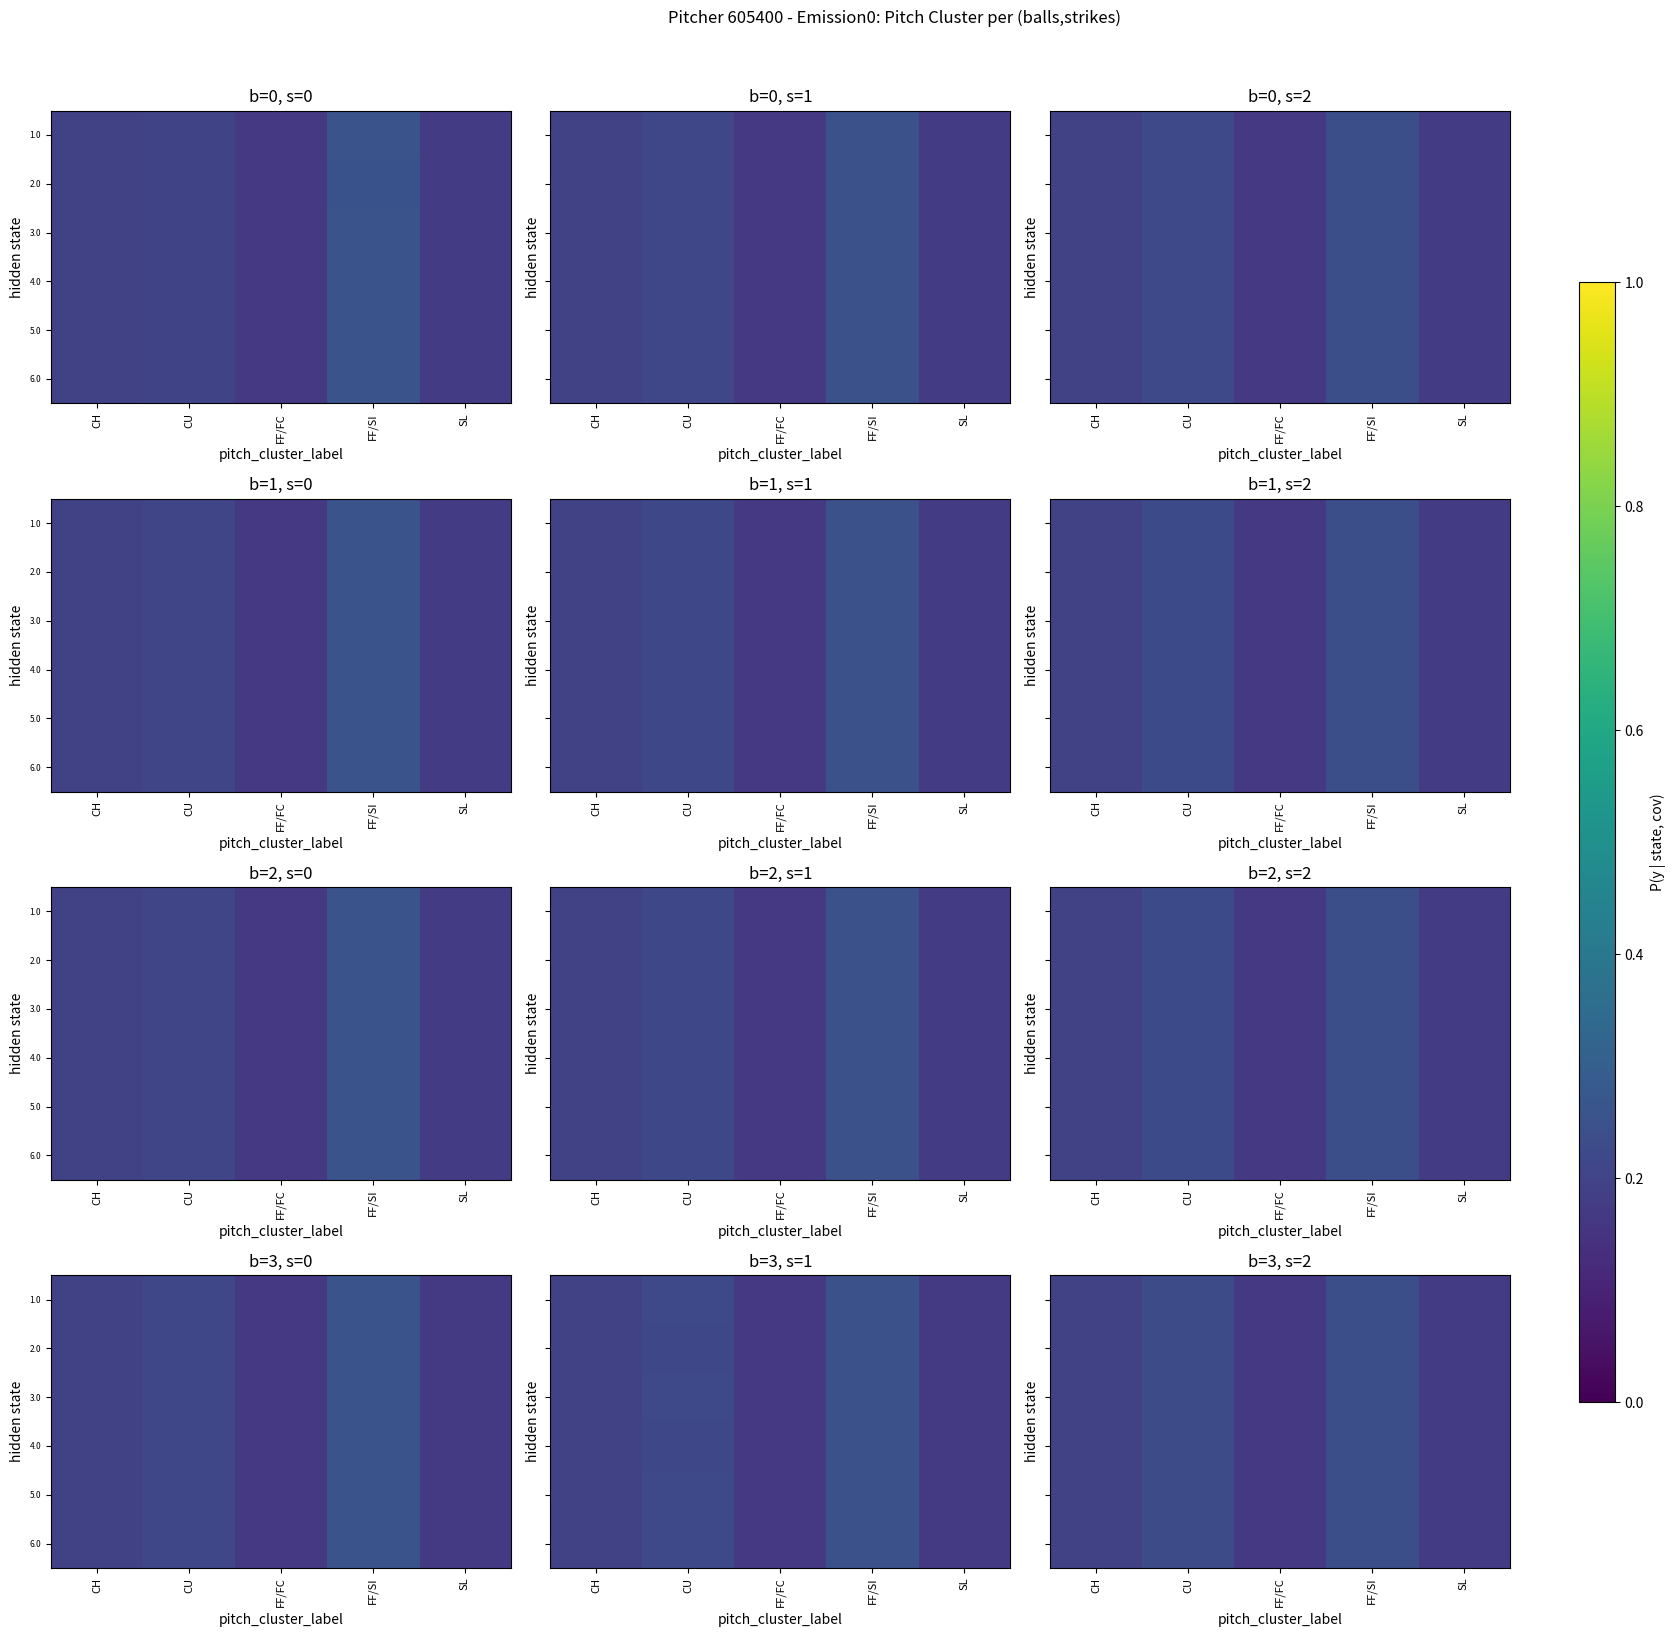

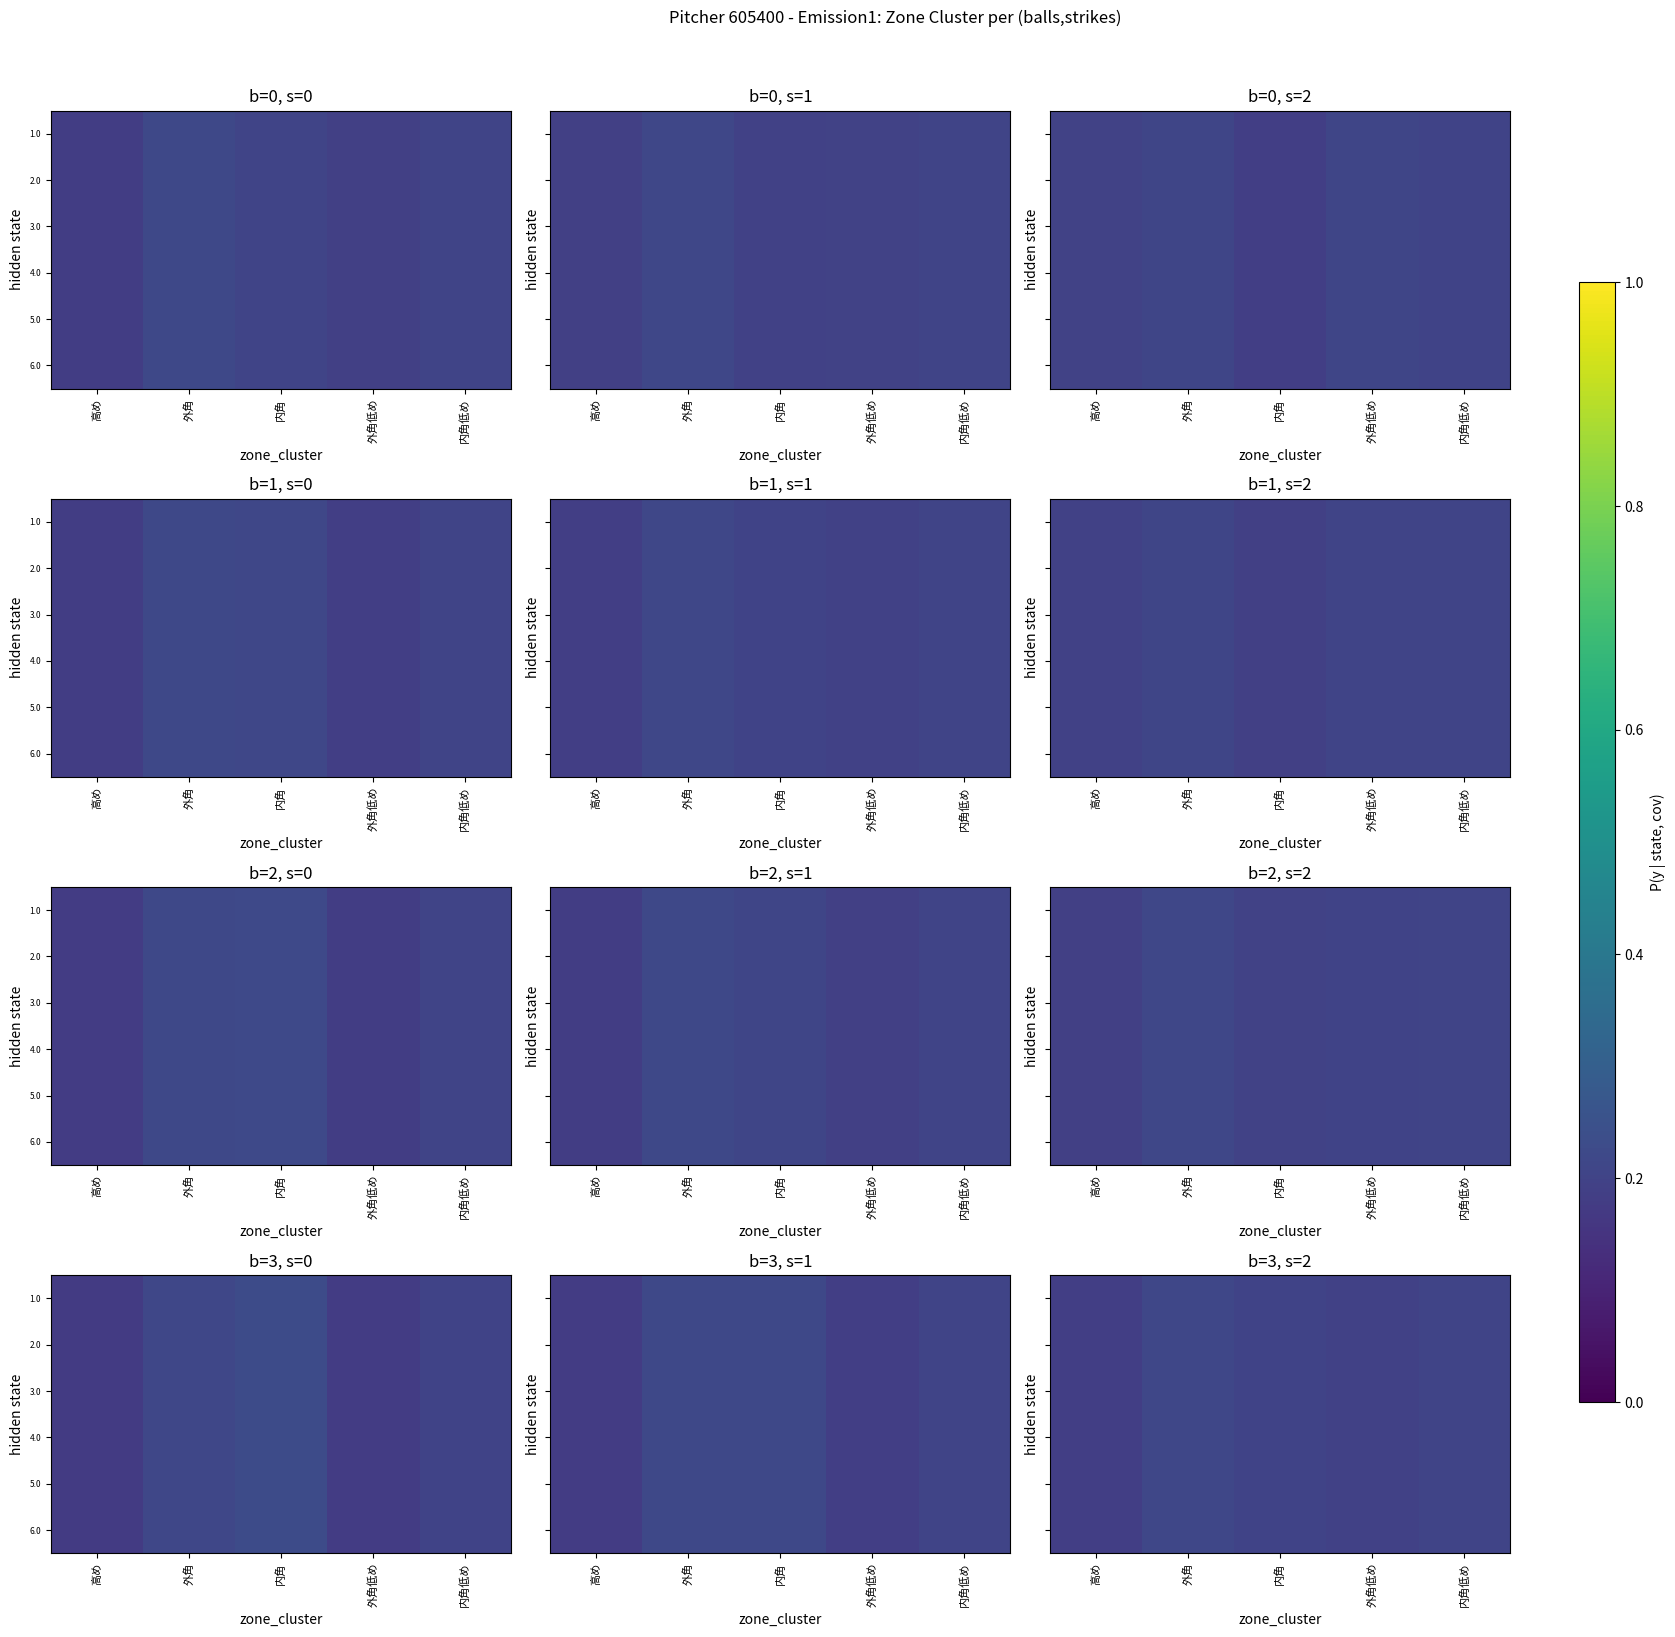

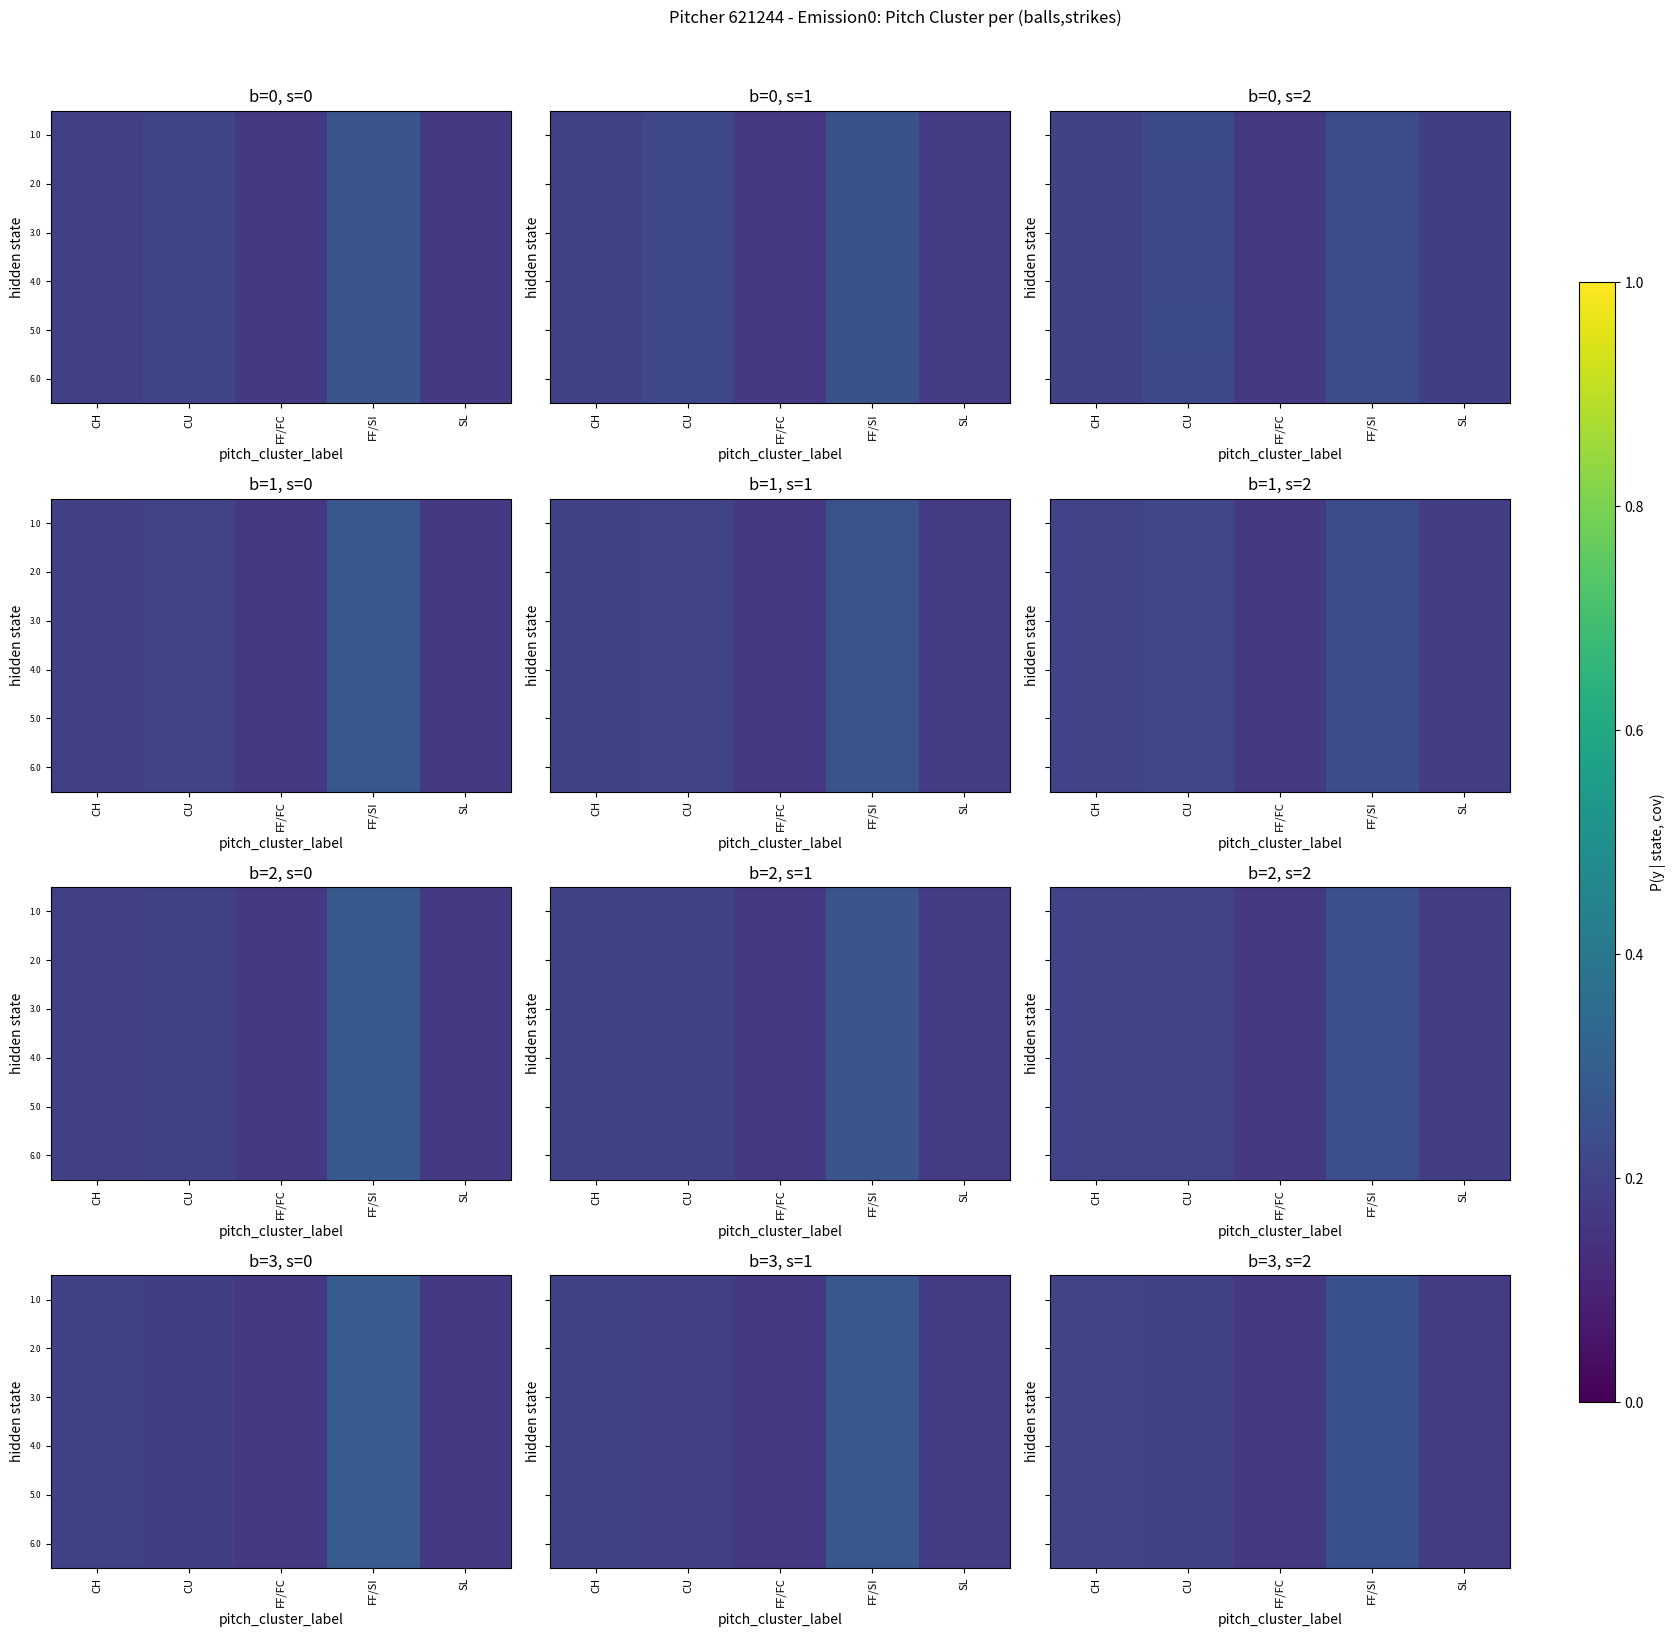

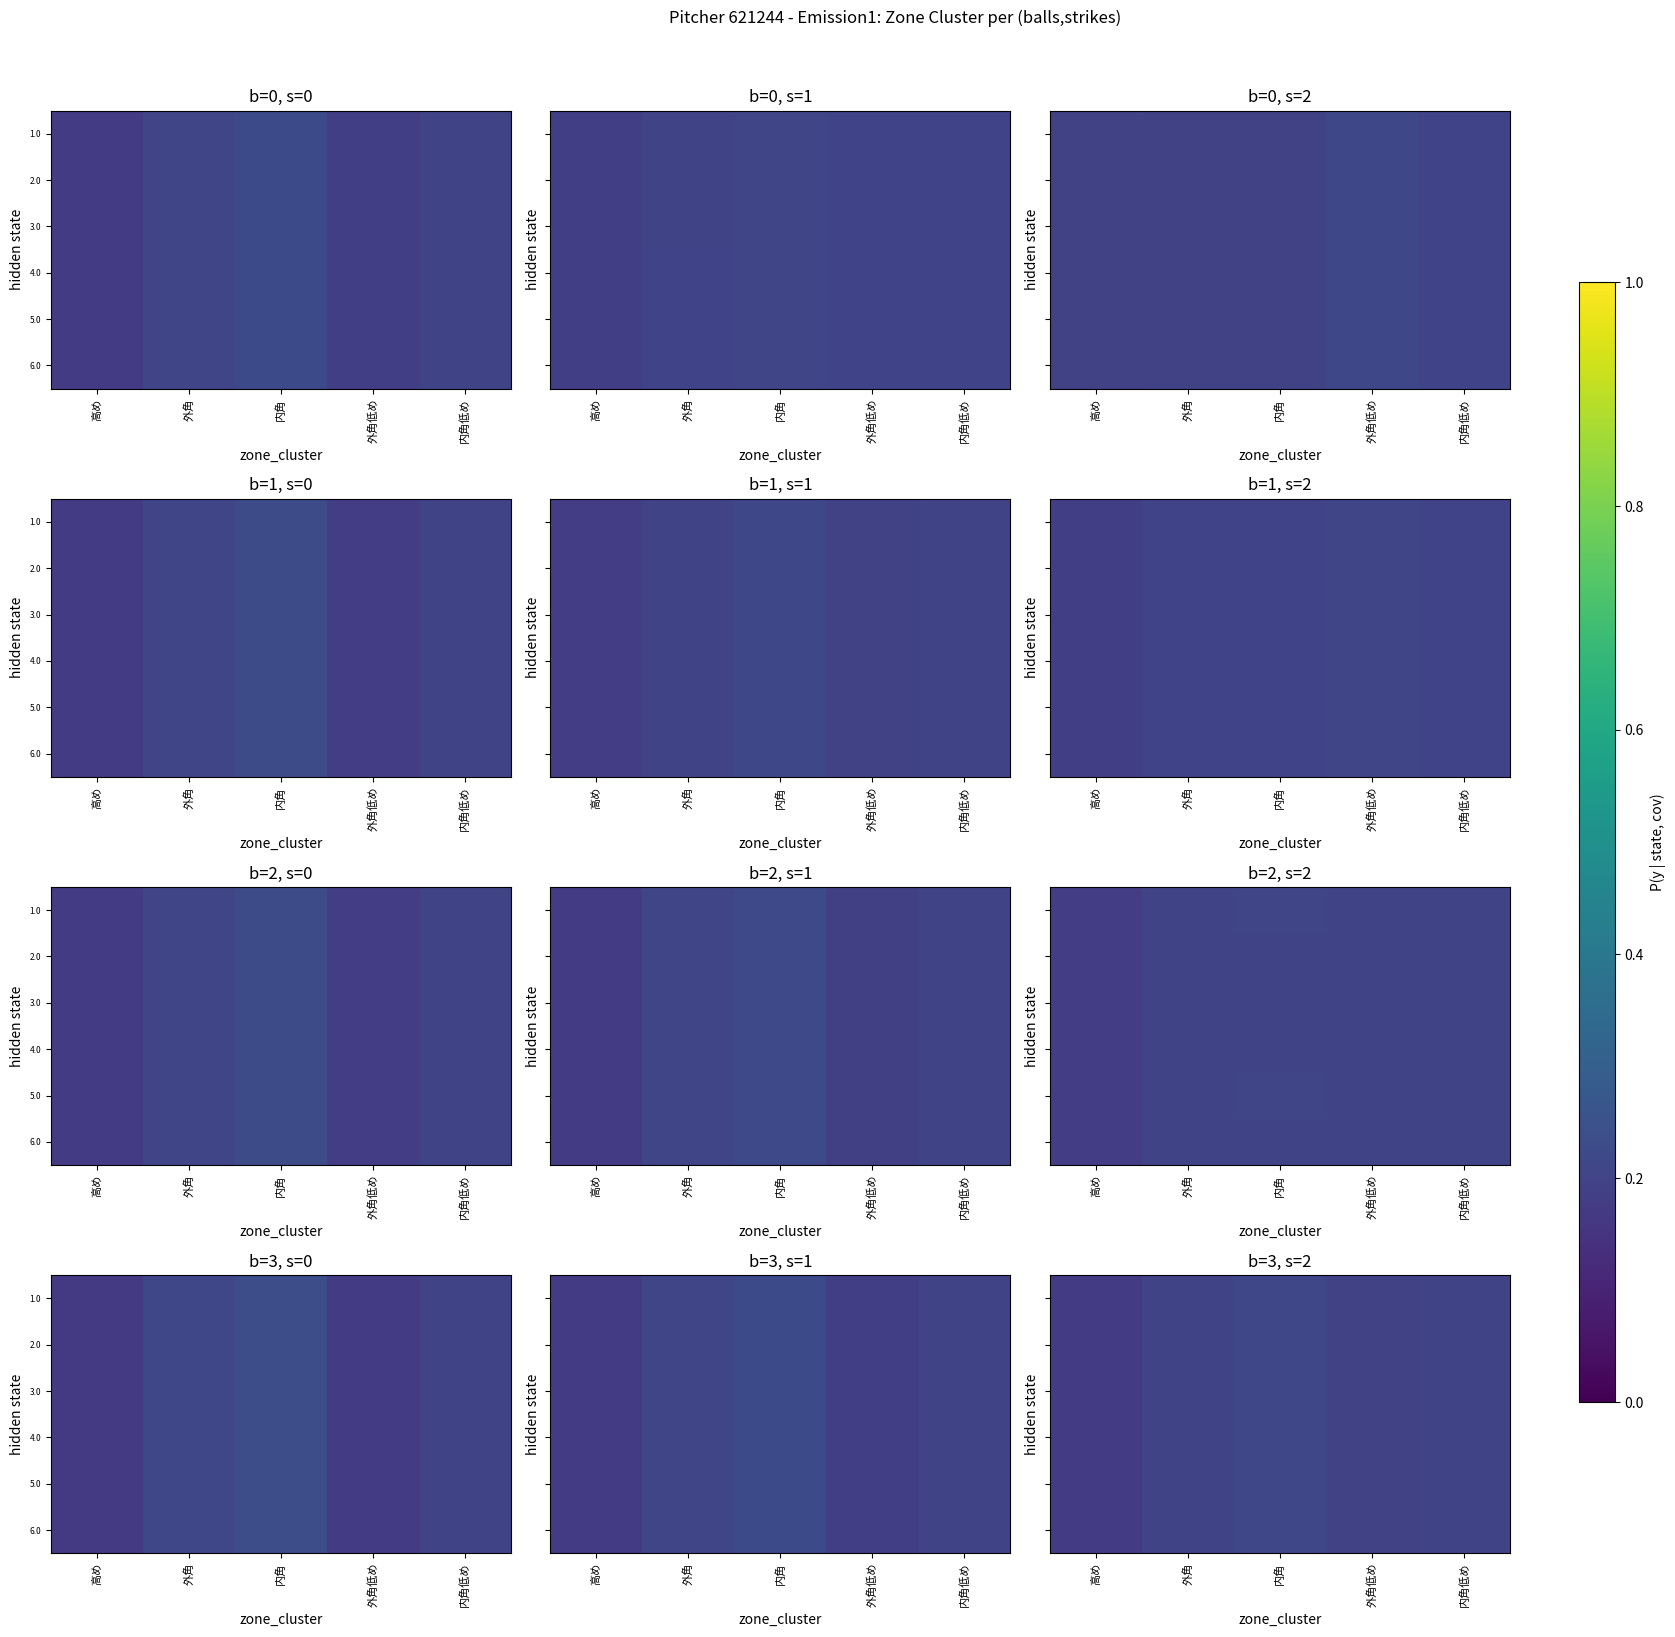

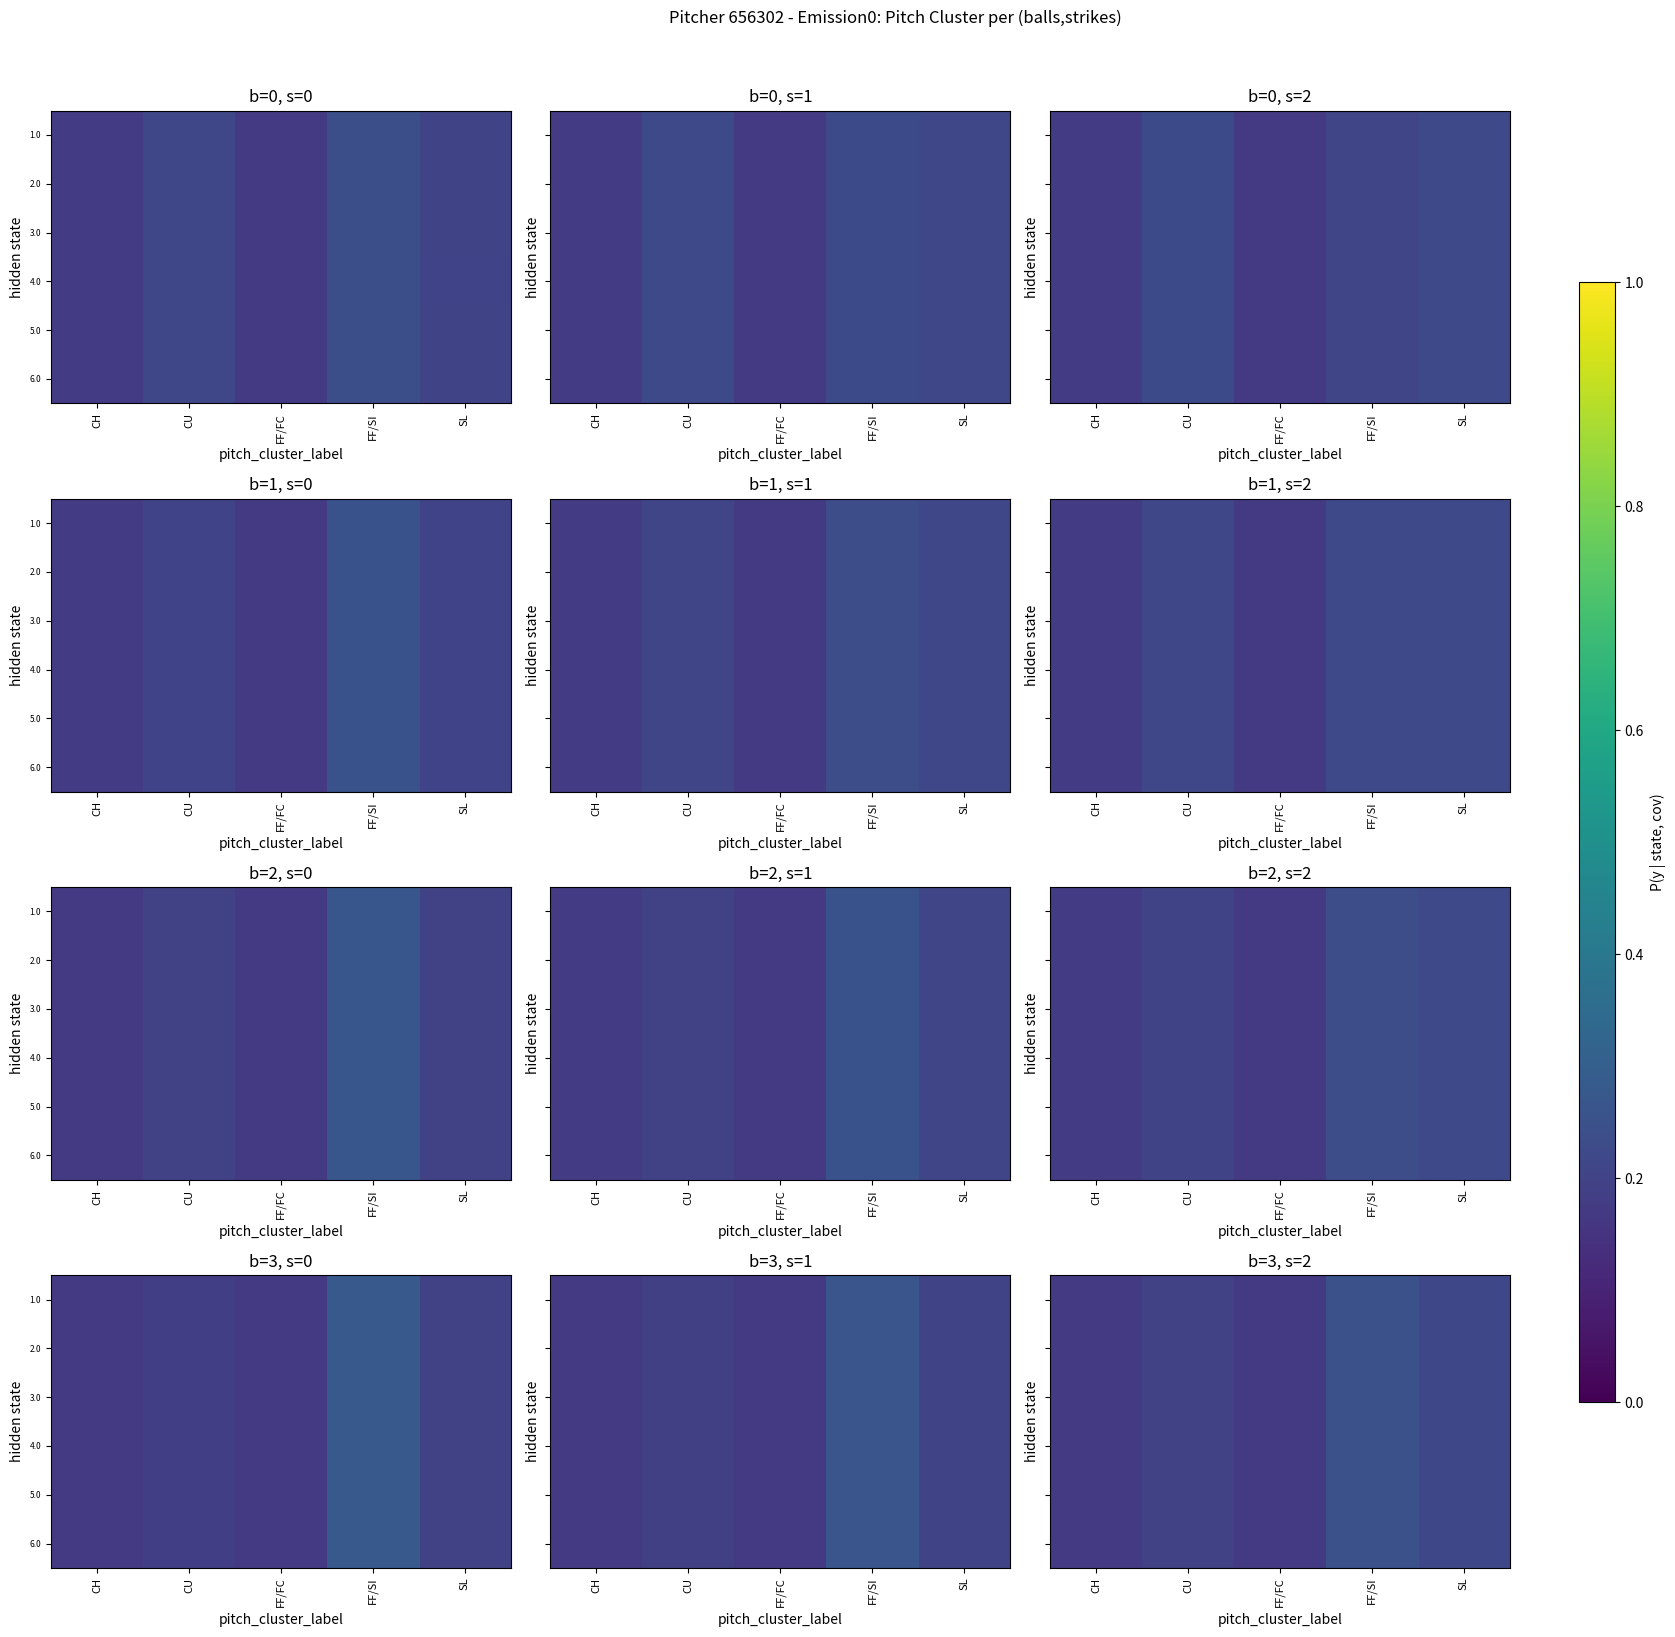

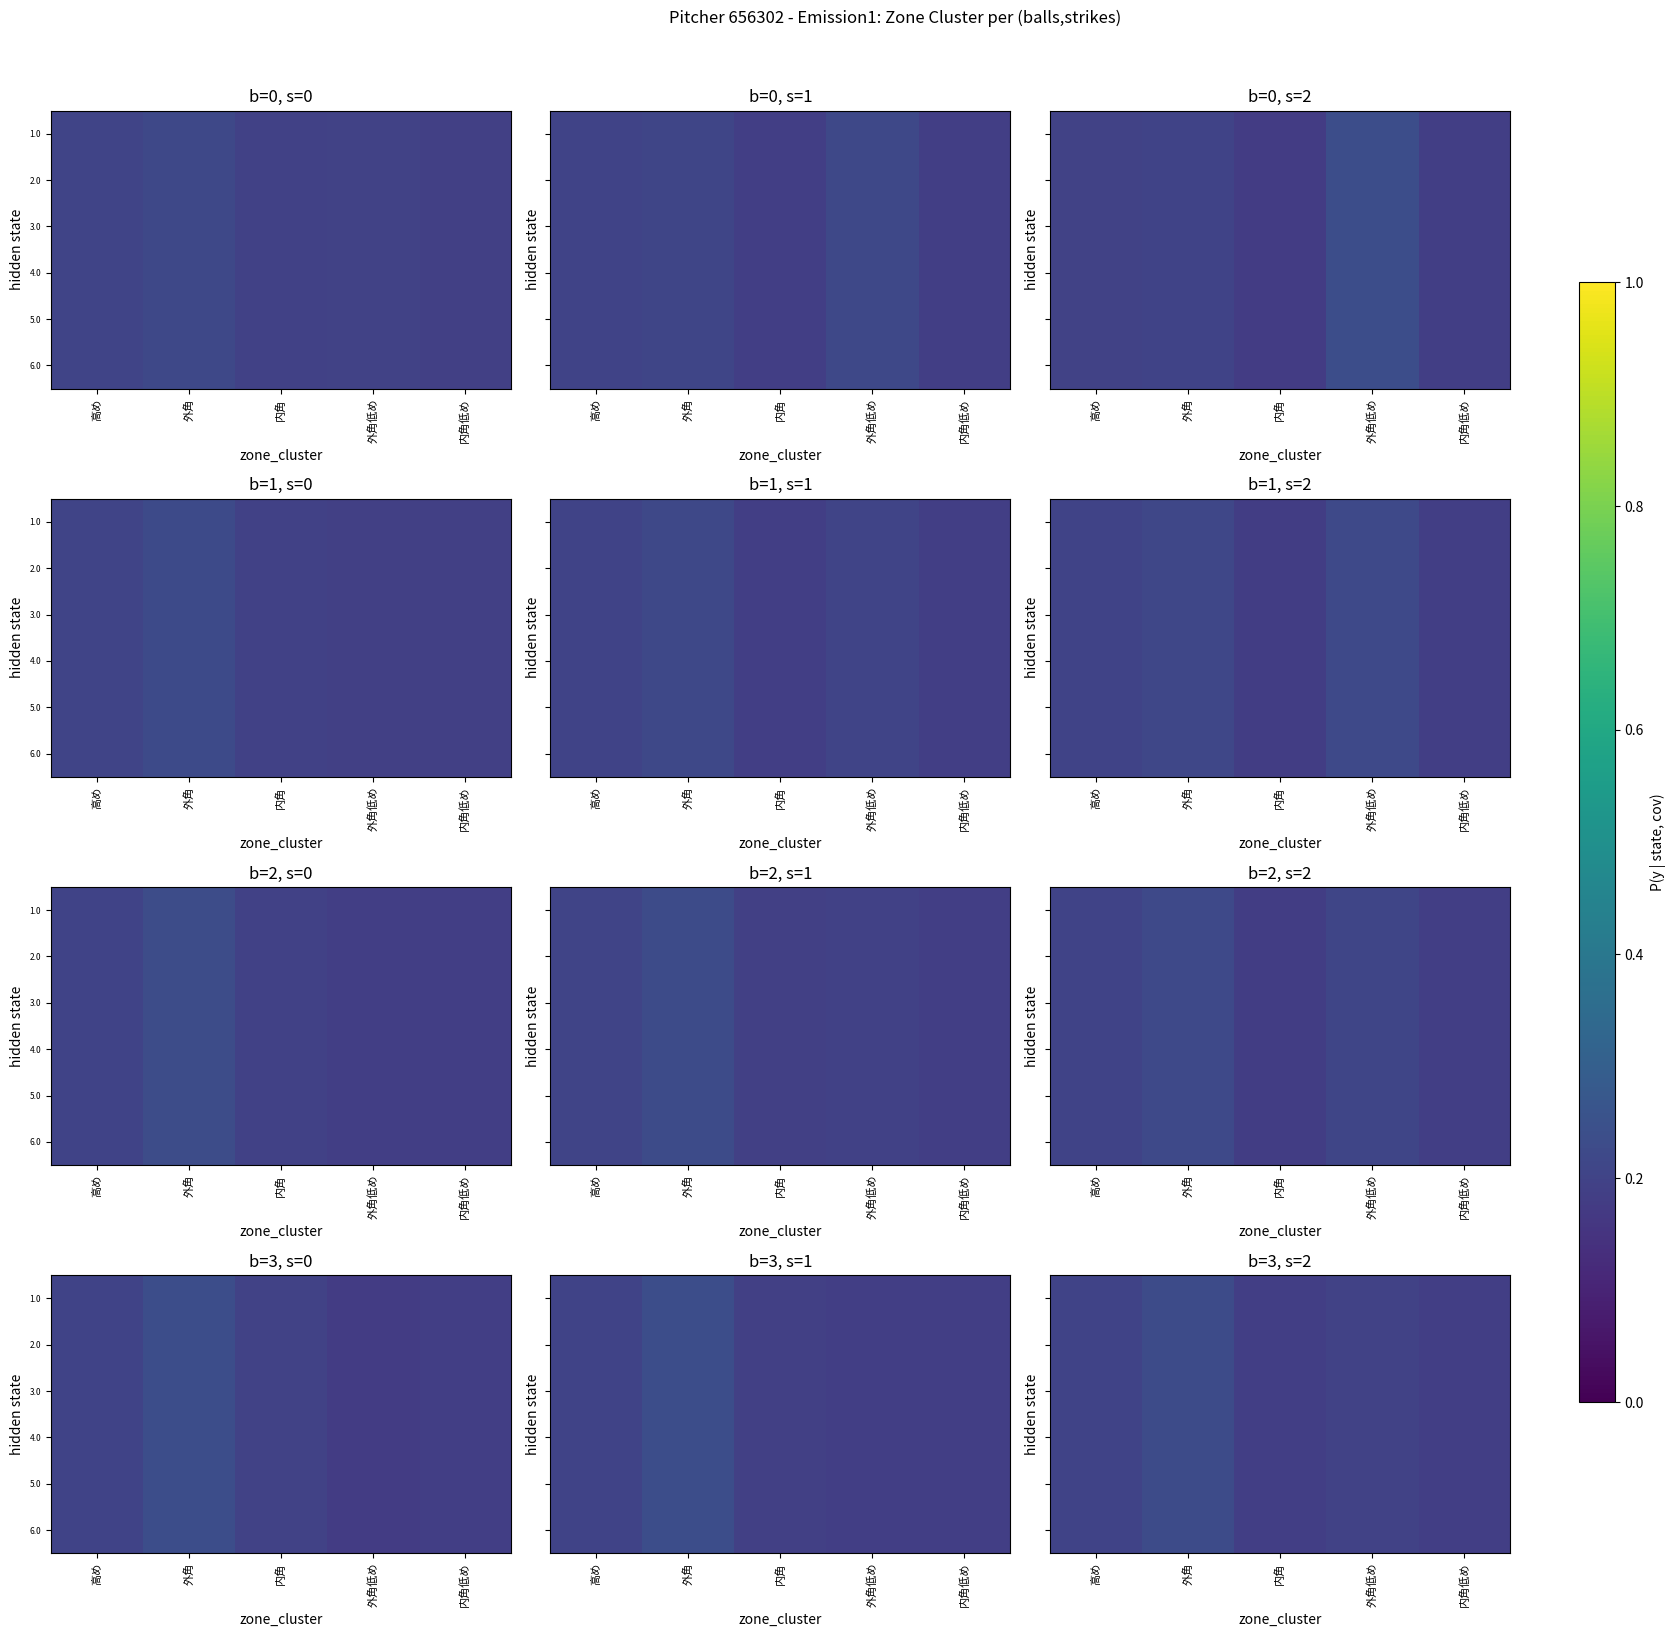

In [18]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from math import ceil
from matplotlib import rcParams
from matplotlib.font_manager import FontProperties

# 投手リスト
pitch_list = ["543037", "554430", "605400", "621244", "656302"]

for pitch in pitch_list:
    model_dir = f"iohmm_{pitch}"

    # モデルファイルは model.pkl だけを探す
    model_fp = os.path.join(model_dir, "unsup6_model.pkl")
    if not os.path.isfile(model_fp):
        print(f"[{pitch}] モデルファイルが見つかりません: {model_fp}")
        continue

    # エンコーダファイルは encoders.pkl だけを探す
    enc_fp = os.path.join(model_dir, "un6_encoders.pkl")
    if not os.path.isfile(enc_fp):
        print(f"[{pitch}] エンコーダファイルが見つかりません: {enc_fp}")
        continue

    # モデルとエンコーダ読み込み
    with open(model_fp, "rb") as mf:
        shmm = pickle.load(mf)
    with open(enc_fp, "rb") as ef:
        encs = pickle.load(ef)

    # 後はこれまでと同じ可視化コードを続けてください…
    le_z   = encs["le_zone"]
    le_pcl = encs["le_pitch_cluster_label"]
    le_zcl = encs["le_zone_cluster"]

    state_labels = le_z.inverse_transform(np.arange(shmm.num_states))
    pcl_labels   = le_pcl.inverse_transform(np.arange(len(le_pcl.classes_)))
    zcl_labels   = le_zcl.inverse_transform(np.arange(len(le_zcl.classes_)))

    covs   = [(b, s) for b in range(4) for s in range(3)]
    n_cov  = len(covs)
    n_cols = 3
    n_rows = ceil(n_cov / n_cols)

    # Emission0, Emission1 の描画をここに…

    # 隠れ状態ラベル復元
    state_labels  = le_z.inverse_transform(np.arange(shmm.num_states))
    # 出力クラスタラベル復元
    pcl_labels = le_pcl.inverse_transform(np.arange(len(le_pcl.classes_)))
    zcl_labels = le_zcl.inverse_transform(np.arange(len(le_zcl.classes_)))

    # covariate パターン
    covs = [(b, s) for b in range(4) for s in range(3)]
    n_cov = len(covs)
    n_cols = 3
    n_rows = ceil(n_cov / n_cols)

    # --- Emission0 (pitch_cluster_label) ---
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4*n_rows), sharey=True)
    axes = axes.flatten()
    fig.suptitle(f"Pitcher {pitch} - Emission0: Pitch Cluster per (balls,strikes)", y=1.02)

    for i, (b, s) in enumerate(covs):
        ax = axes[i]
        emis0 = np.vstack([
            np.exp(shmm.model_emissions[state][0]
                   .predict_log_proba(np.array([[b, s]])))[0]
            for state in range(shmm.num_states)
        ])
        im = ax.imshow(emis0, vmin=0, vmax=1, aspect='auto', cmap=cm.viridis)
        # Noto Sans CJK を指定
        jp_font = FontProperties(fname='/usr/share/fonts/opentype/noto/NotoSansCJK-DemiLight.ttc')

        # 日本語フォント設定
        rcParams['font.family'] = jp_font.get_name()
        rcParams['axes.unicode_minus'] = False  # マイナス記号の文字化け対策
        ax.set_title(f"b={b}, s={s}")
        ax.set_xticks(range(len(pcl_labels)))
        ax.set_xticklabels(pcl_labels, rotation=90, fontsize=8)
        ax.set_yticks(range(len(state_labels)))
        ax.set_yticklabels(state_labels, fontsize=6)
        ax.set_xlabel("pitch_cluster_label")
        ax.set_ylabel("hidden state")

    for j in range(n_cov, len(axes)):
        axes[j].axis("off")

    cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax, label="P(y | state, cov)")
    plt.tight_layout(rect=[0,0,0.85,1.0])
    plt.show()

    # --- Emission1 (zone_cluster) ---
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4*n_rows), sharey=True)
    axes = axes.flatten()
    fig.suptitle(f"Pitcher {pitch} - Emission1: Zone Cluster per (balls,strikes)", y=1.02)

    # 日本語ラベルマップ
    zone_map = {0: "高め", 1: "外角", 2: "内角", 3: "外角低め", 4: "内角低め"}
    zcl_names = [zone_map[int(lbl)] for lbl in zcl_labels]

    for i, (b, s) in enumerate(covs):
        ax = axes[i]
        emis1 = np.vstack([
            np.exp(shmm.model_emissions[state][1]
                   .predict_log_proba(np.array([[b, s]])))[0]
            for state in range(shmm.num_states)
        ])
        im = ax.imshow(emis1, vmin=0, vmax=1, aspect='auto', cmap=cm.viridis)
        # Noto Sans CJK を指定
        jp_font = FontProperties(fname='/usr/share/fonts/opentype/noto/NotoSansCJK-DemiLight.ttc')

        # 日本語フォント設定
        rcParams['font.family'] = jp_font.get_name()
        rcParams['axes.unicode_minus'] = False  # マイナス記号の文字化け対策
        ax.set_title(f"b={b}, s={s}")
        ax.set_xticks(range(len(zcl_names)))
        ax.set_xticklabels(zcl_names, rotation=90, fontsize=8)
        ax.set_yticks(range(len(state_labels)))
        ax.set_yticklabels(state_labels, fontsize=6)
        ax.set_xlabel("zone_cluster")
        ax.set_ylabel("hidden state")

    for j in range(n_cov, len(axes)):
        axes[j].axis("off")

    cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax, label="P(y | state, cov)")
    plt.tight_layout(rect=[0,0,0.85,1.0])
    plt.show()


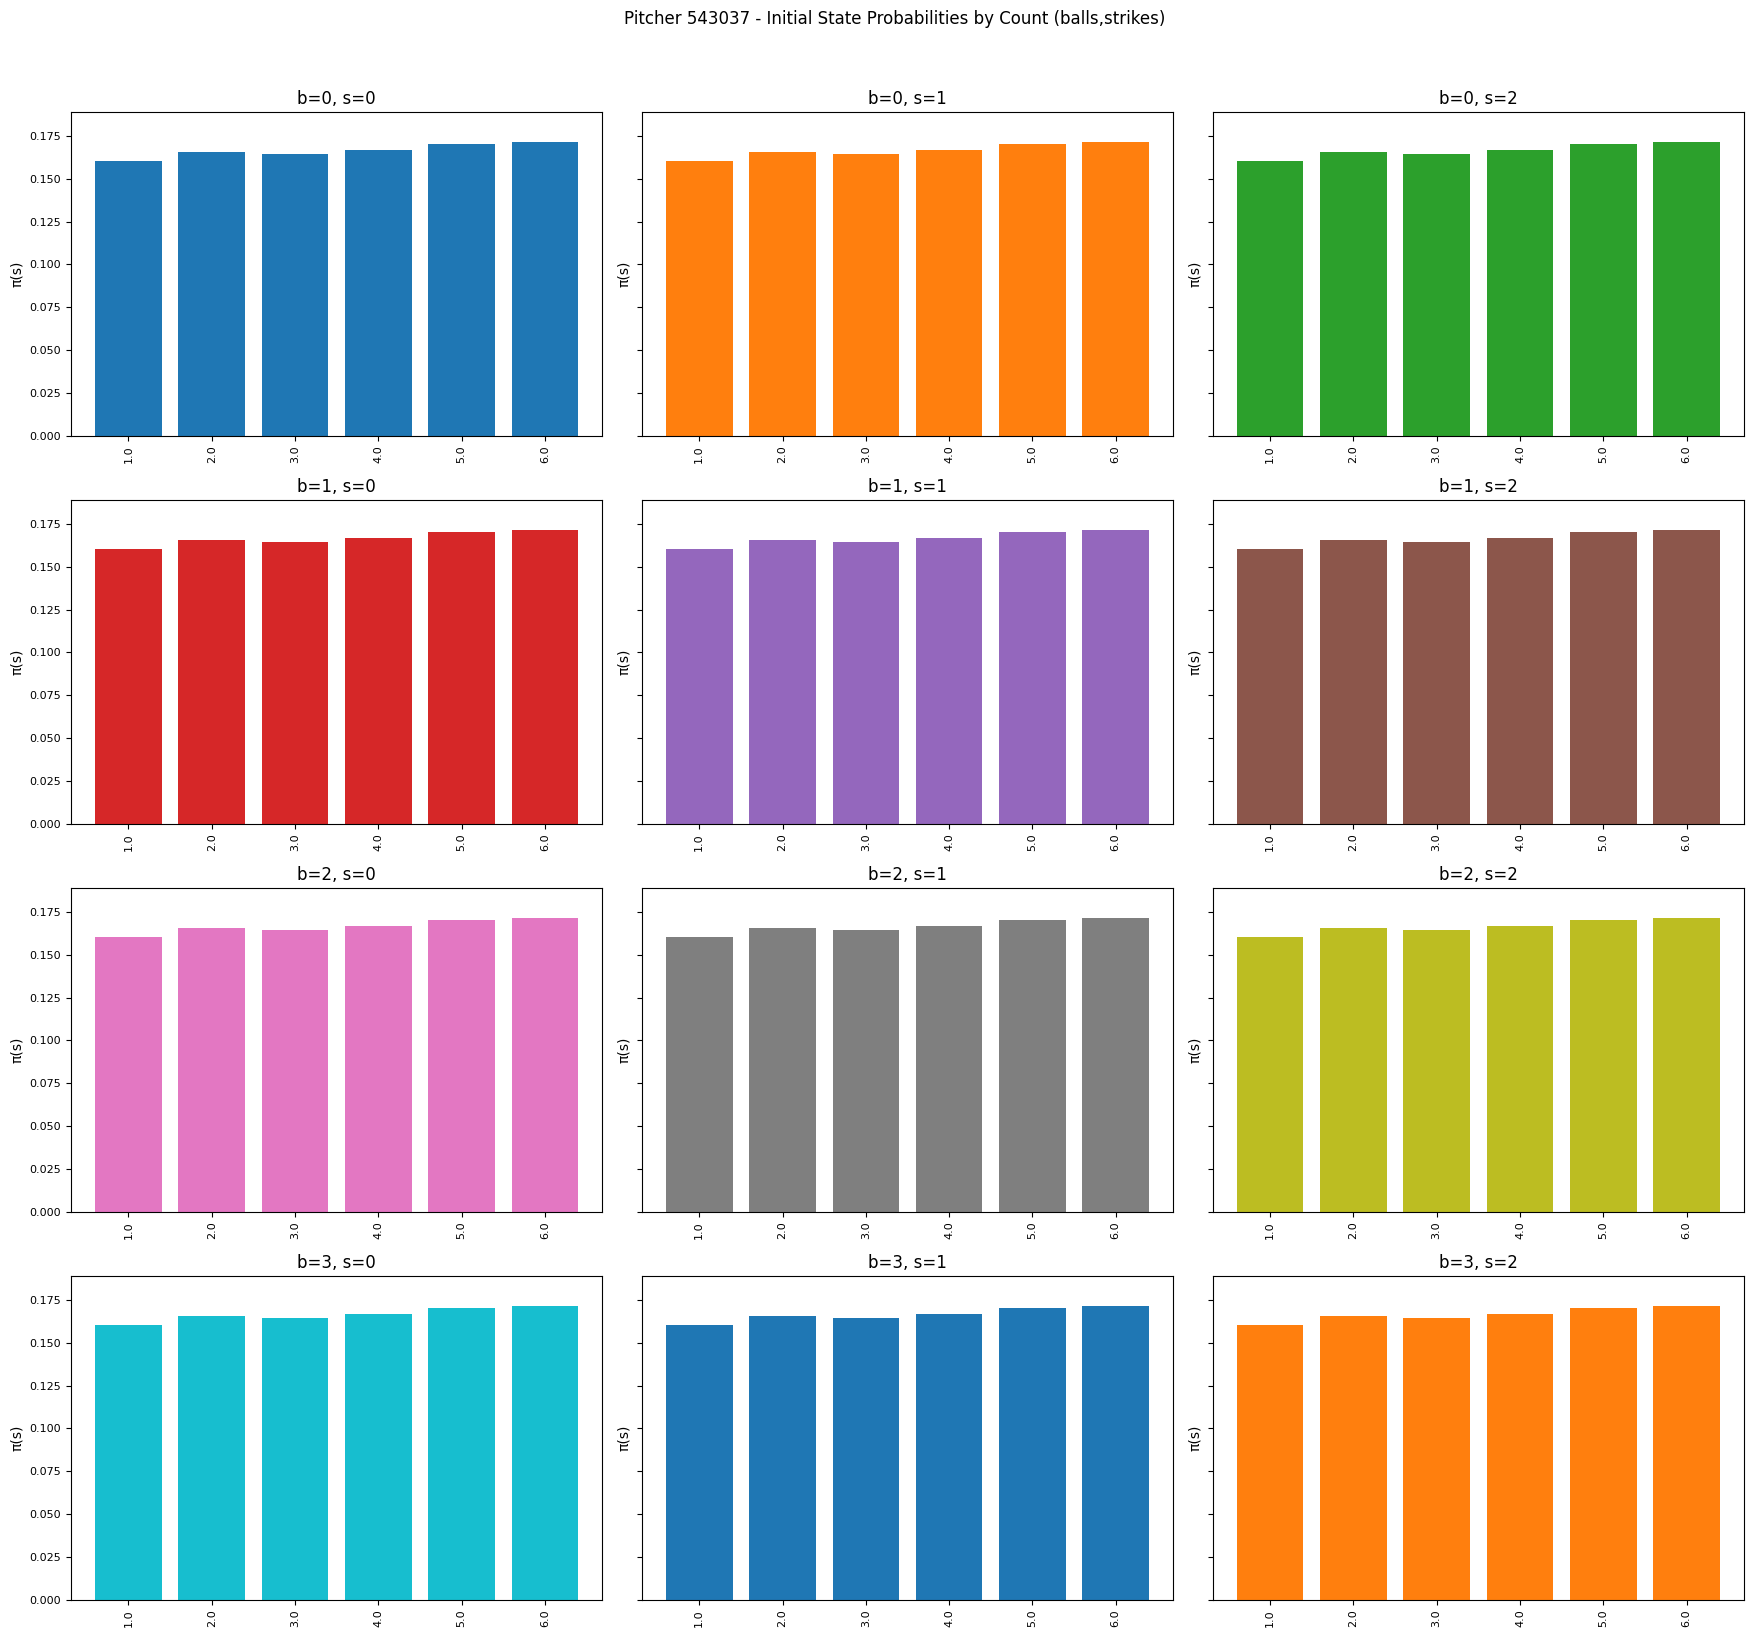

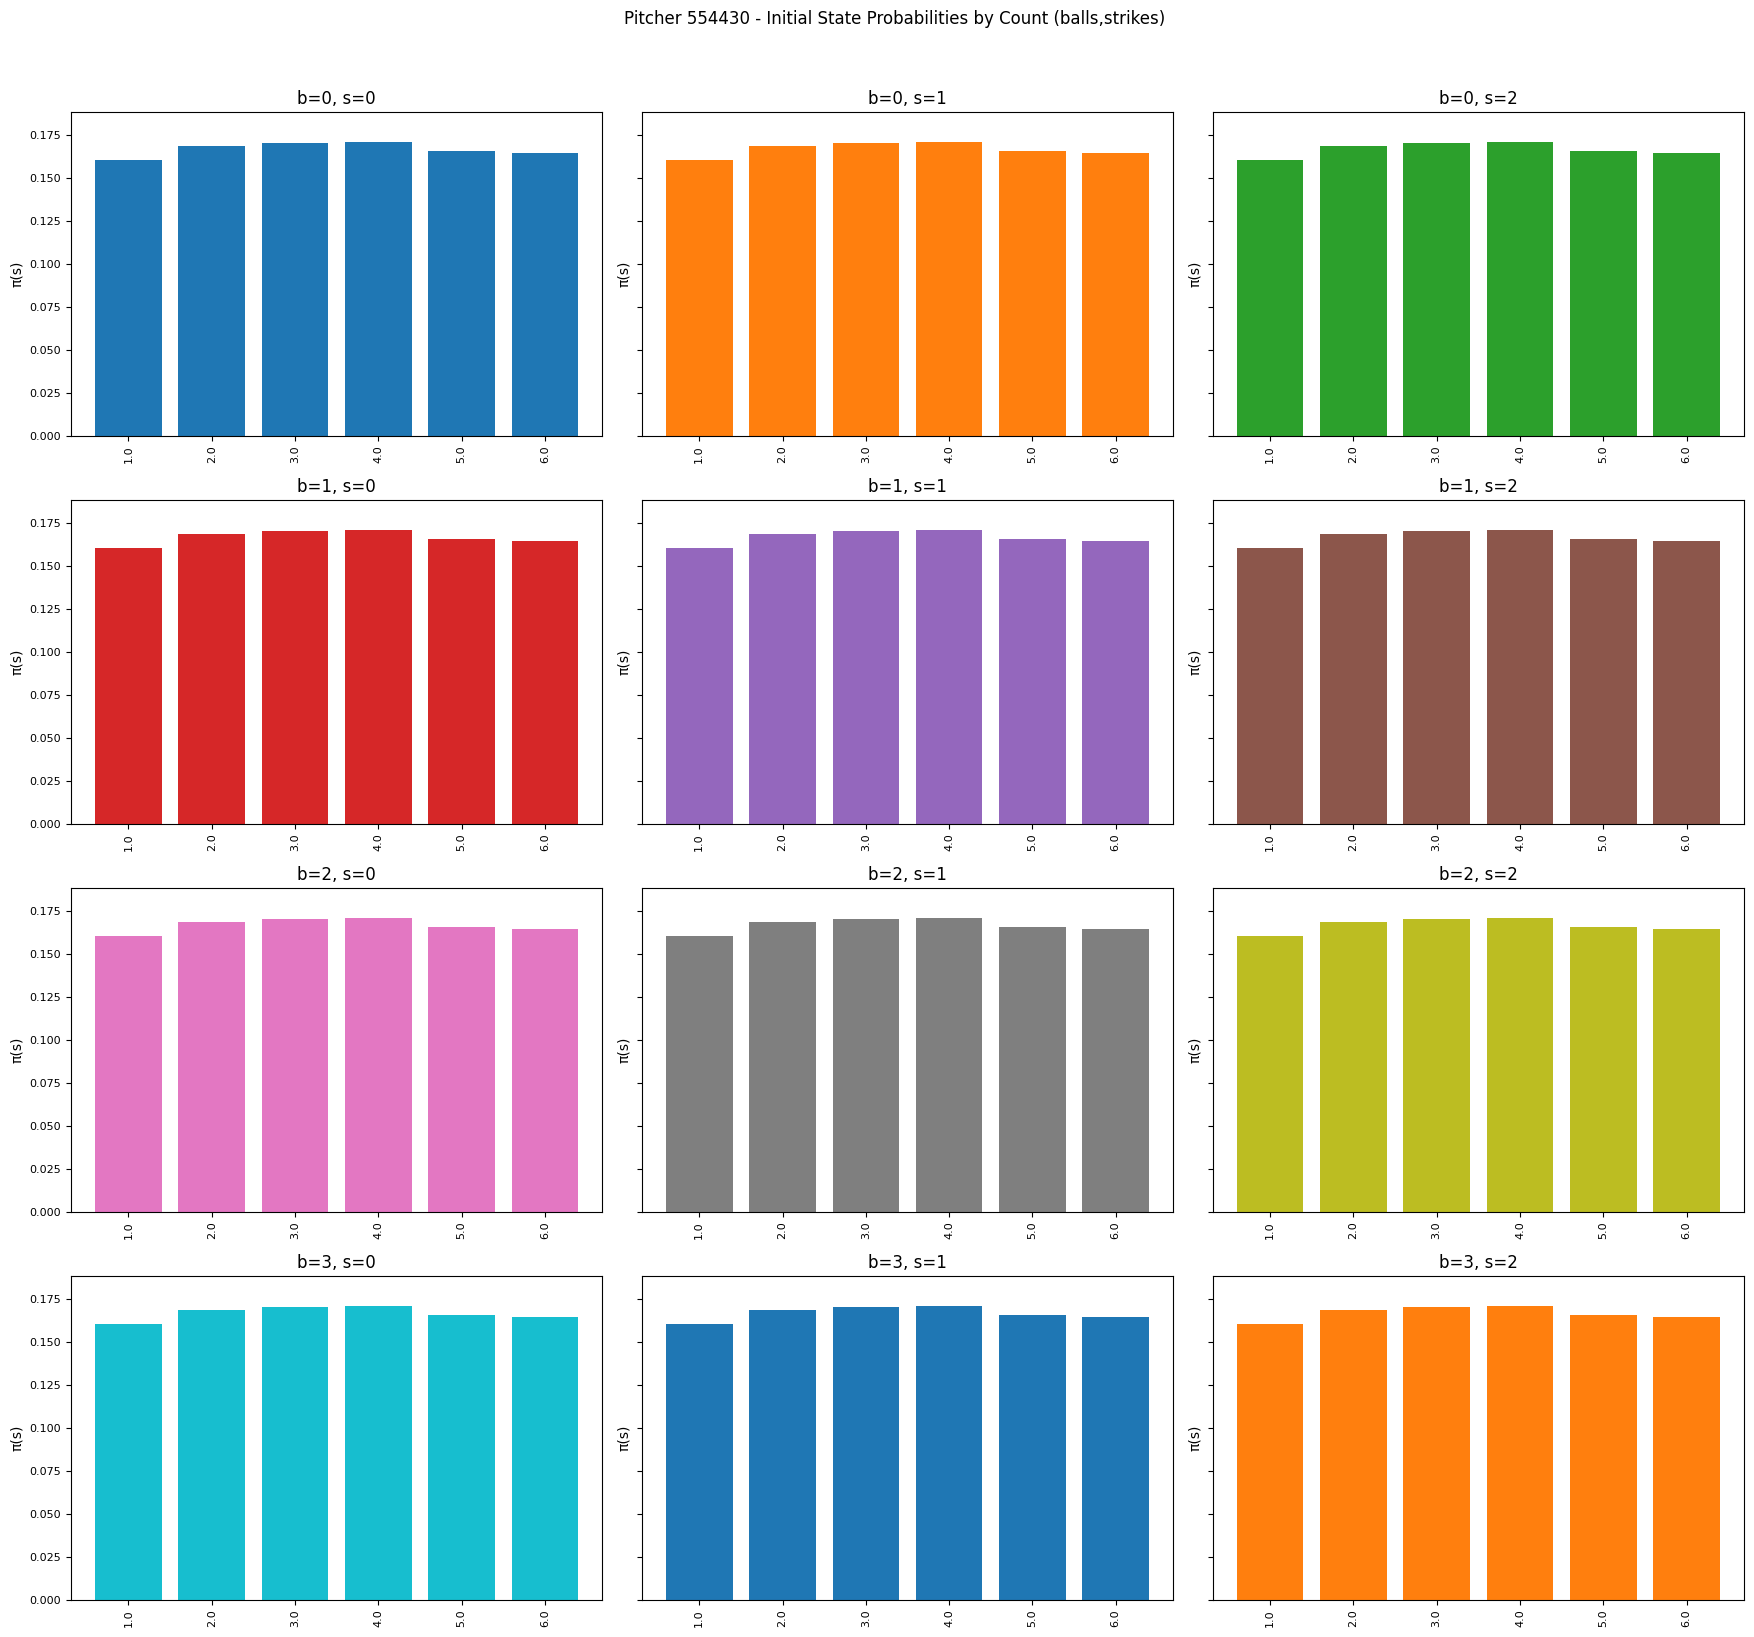

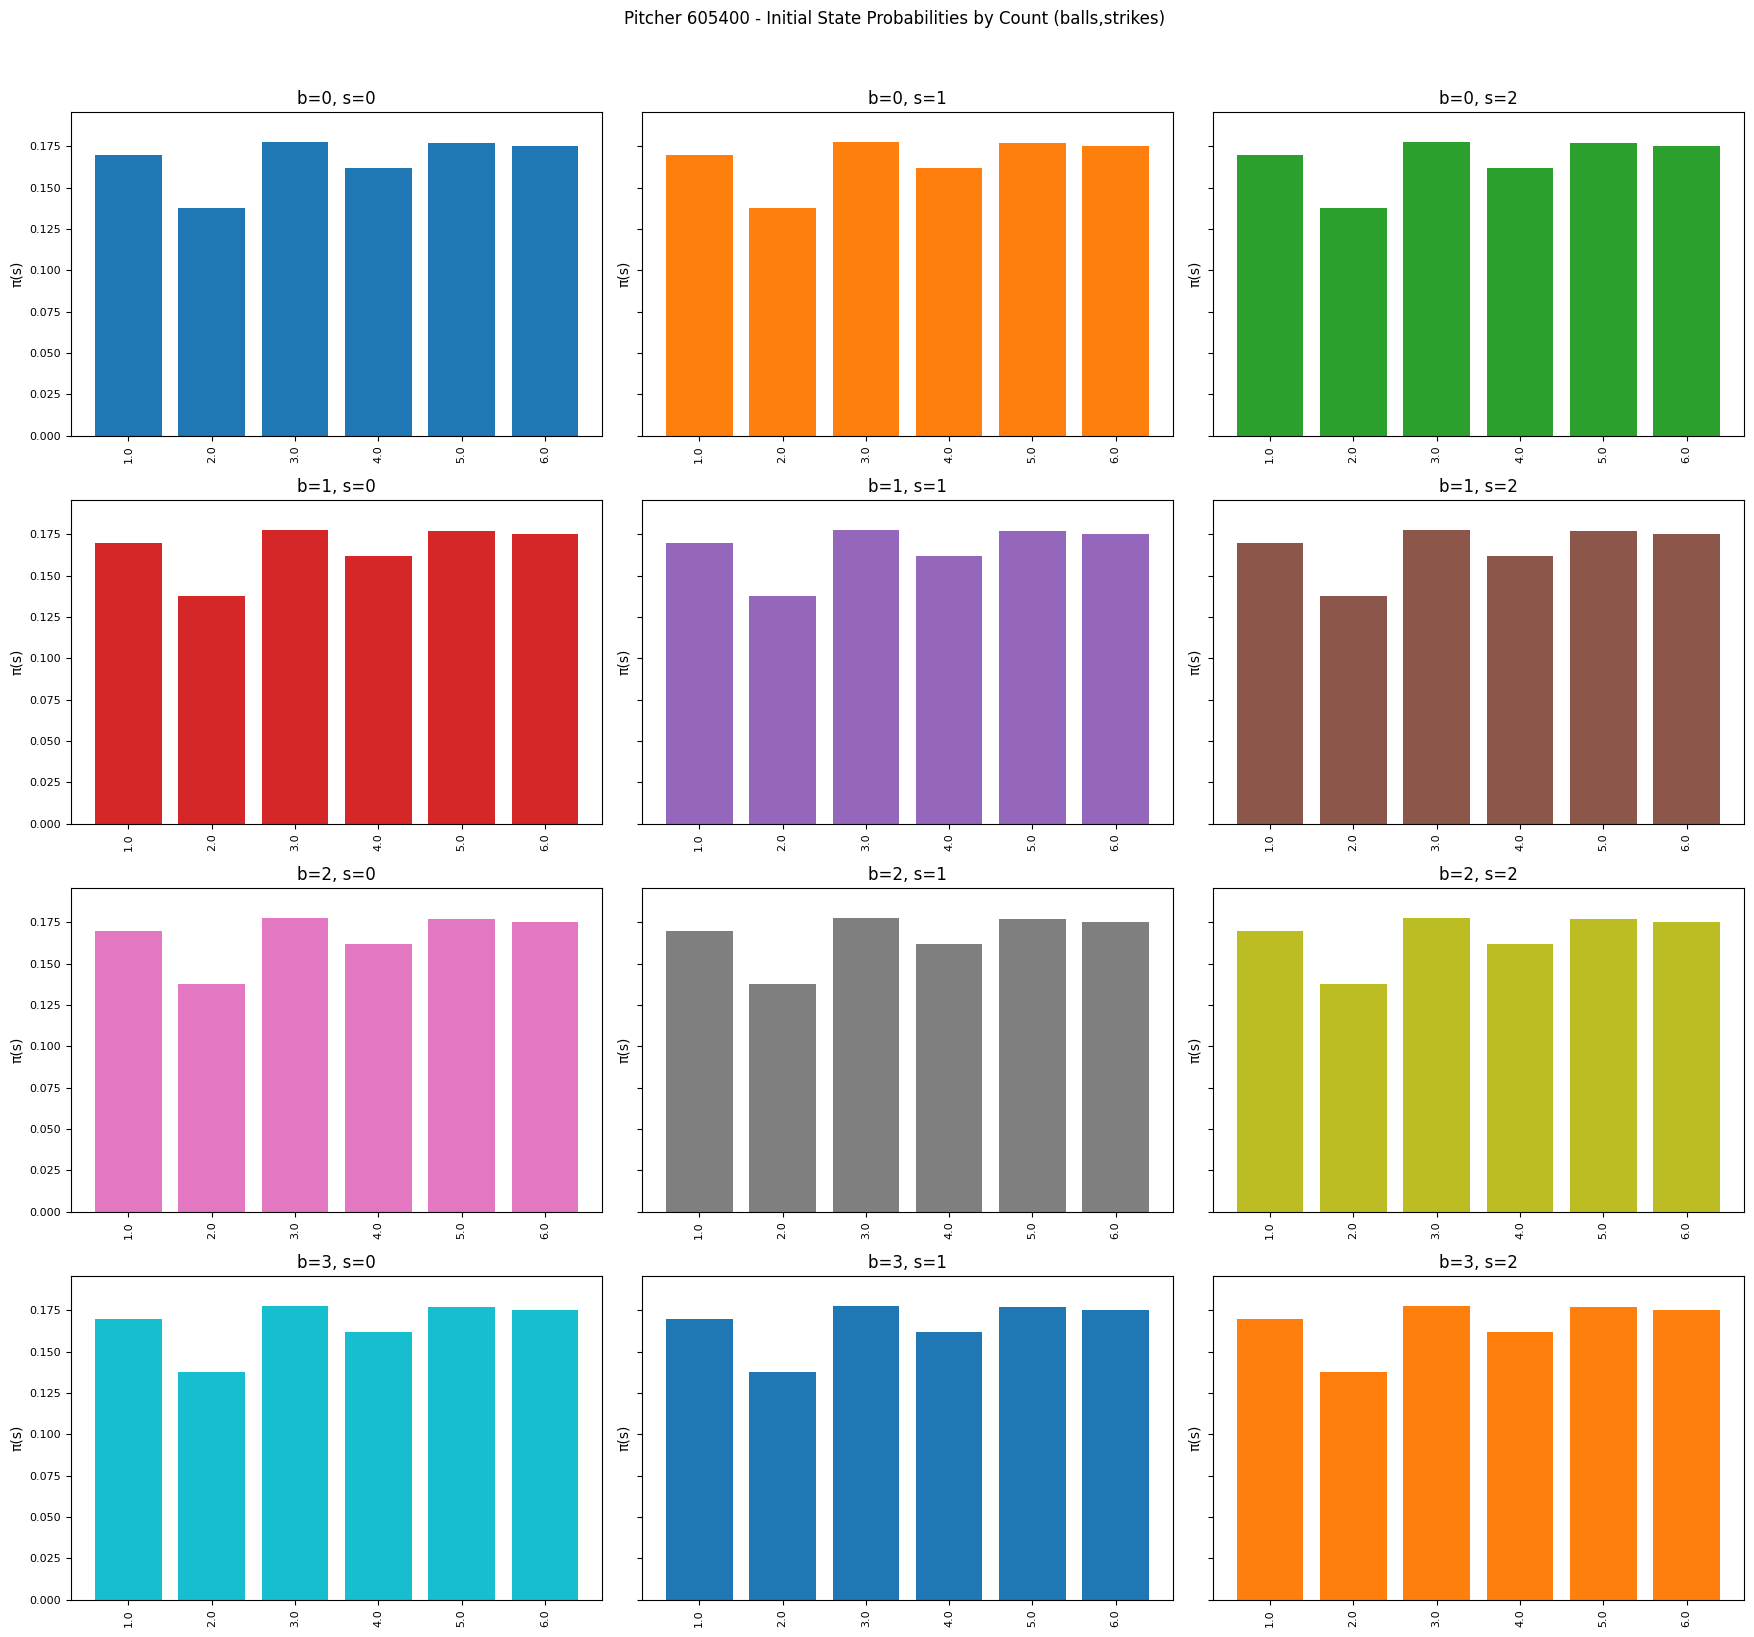

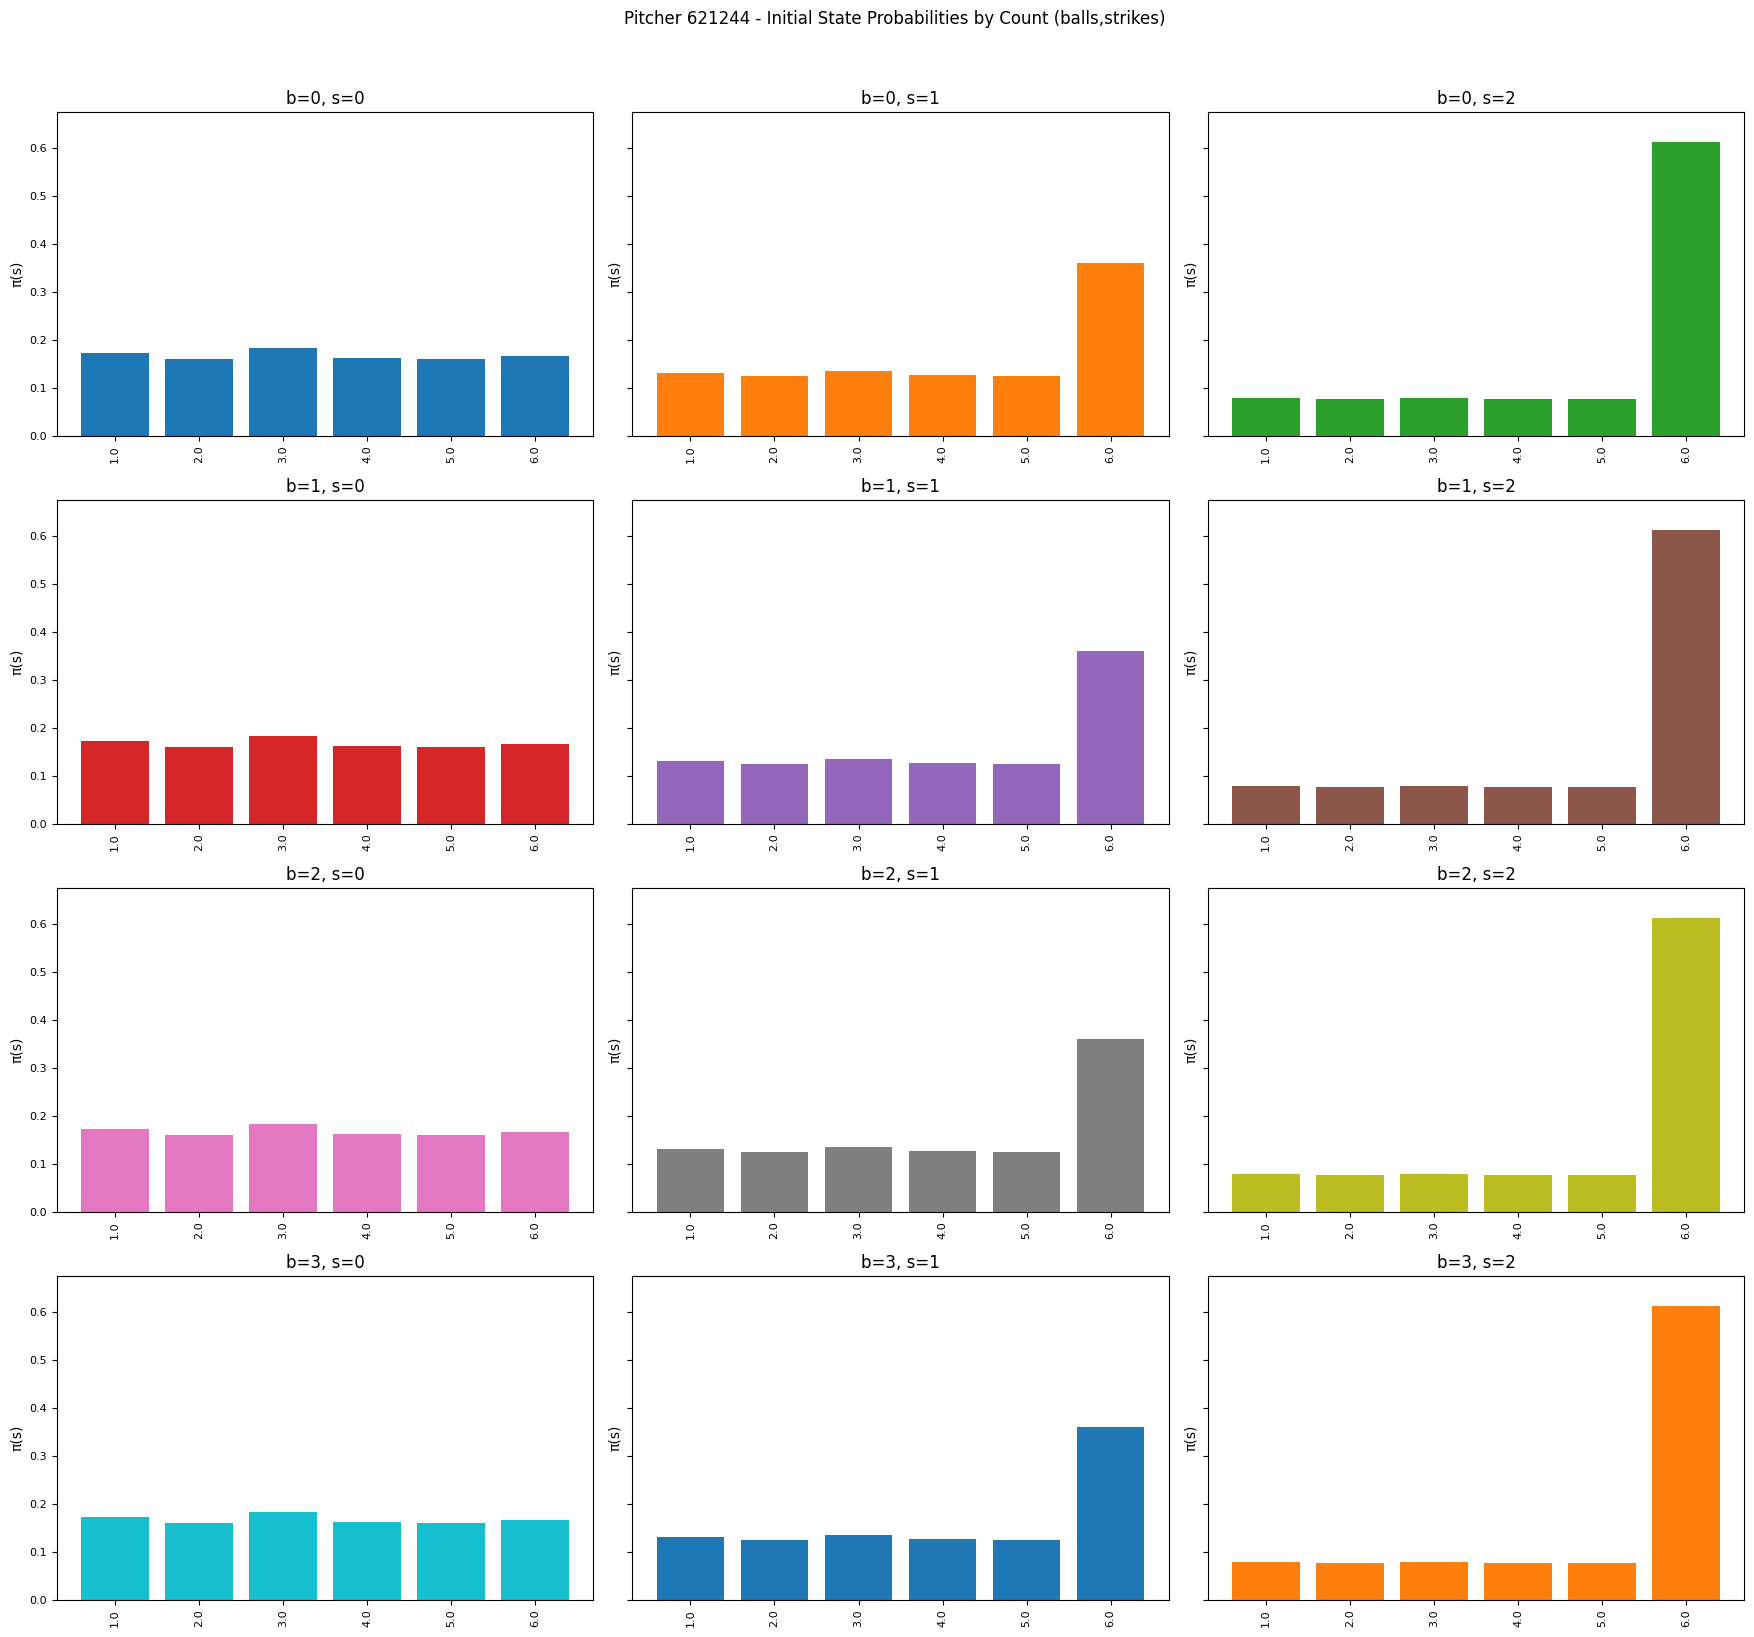

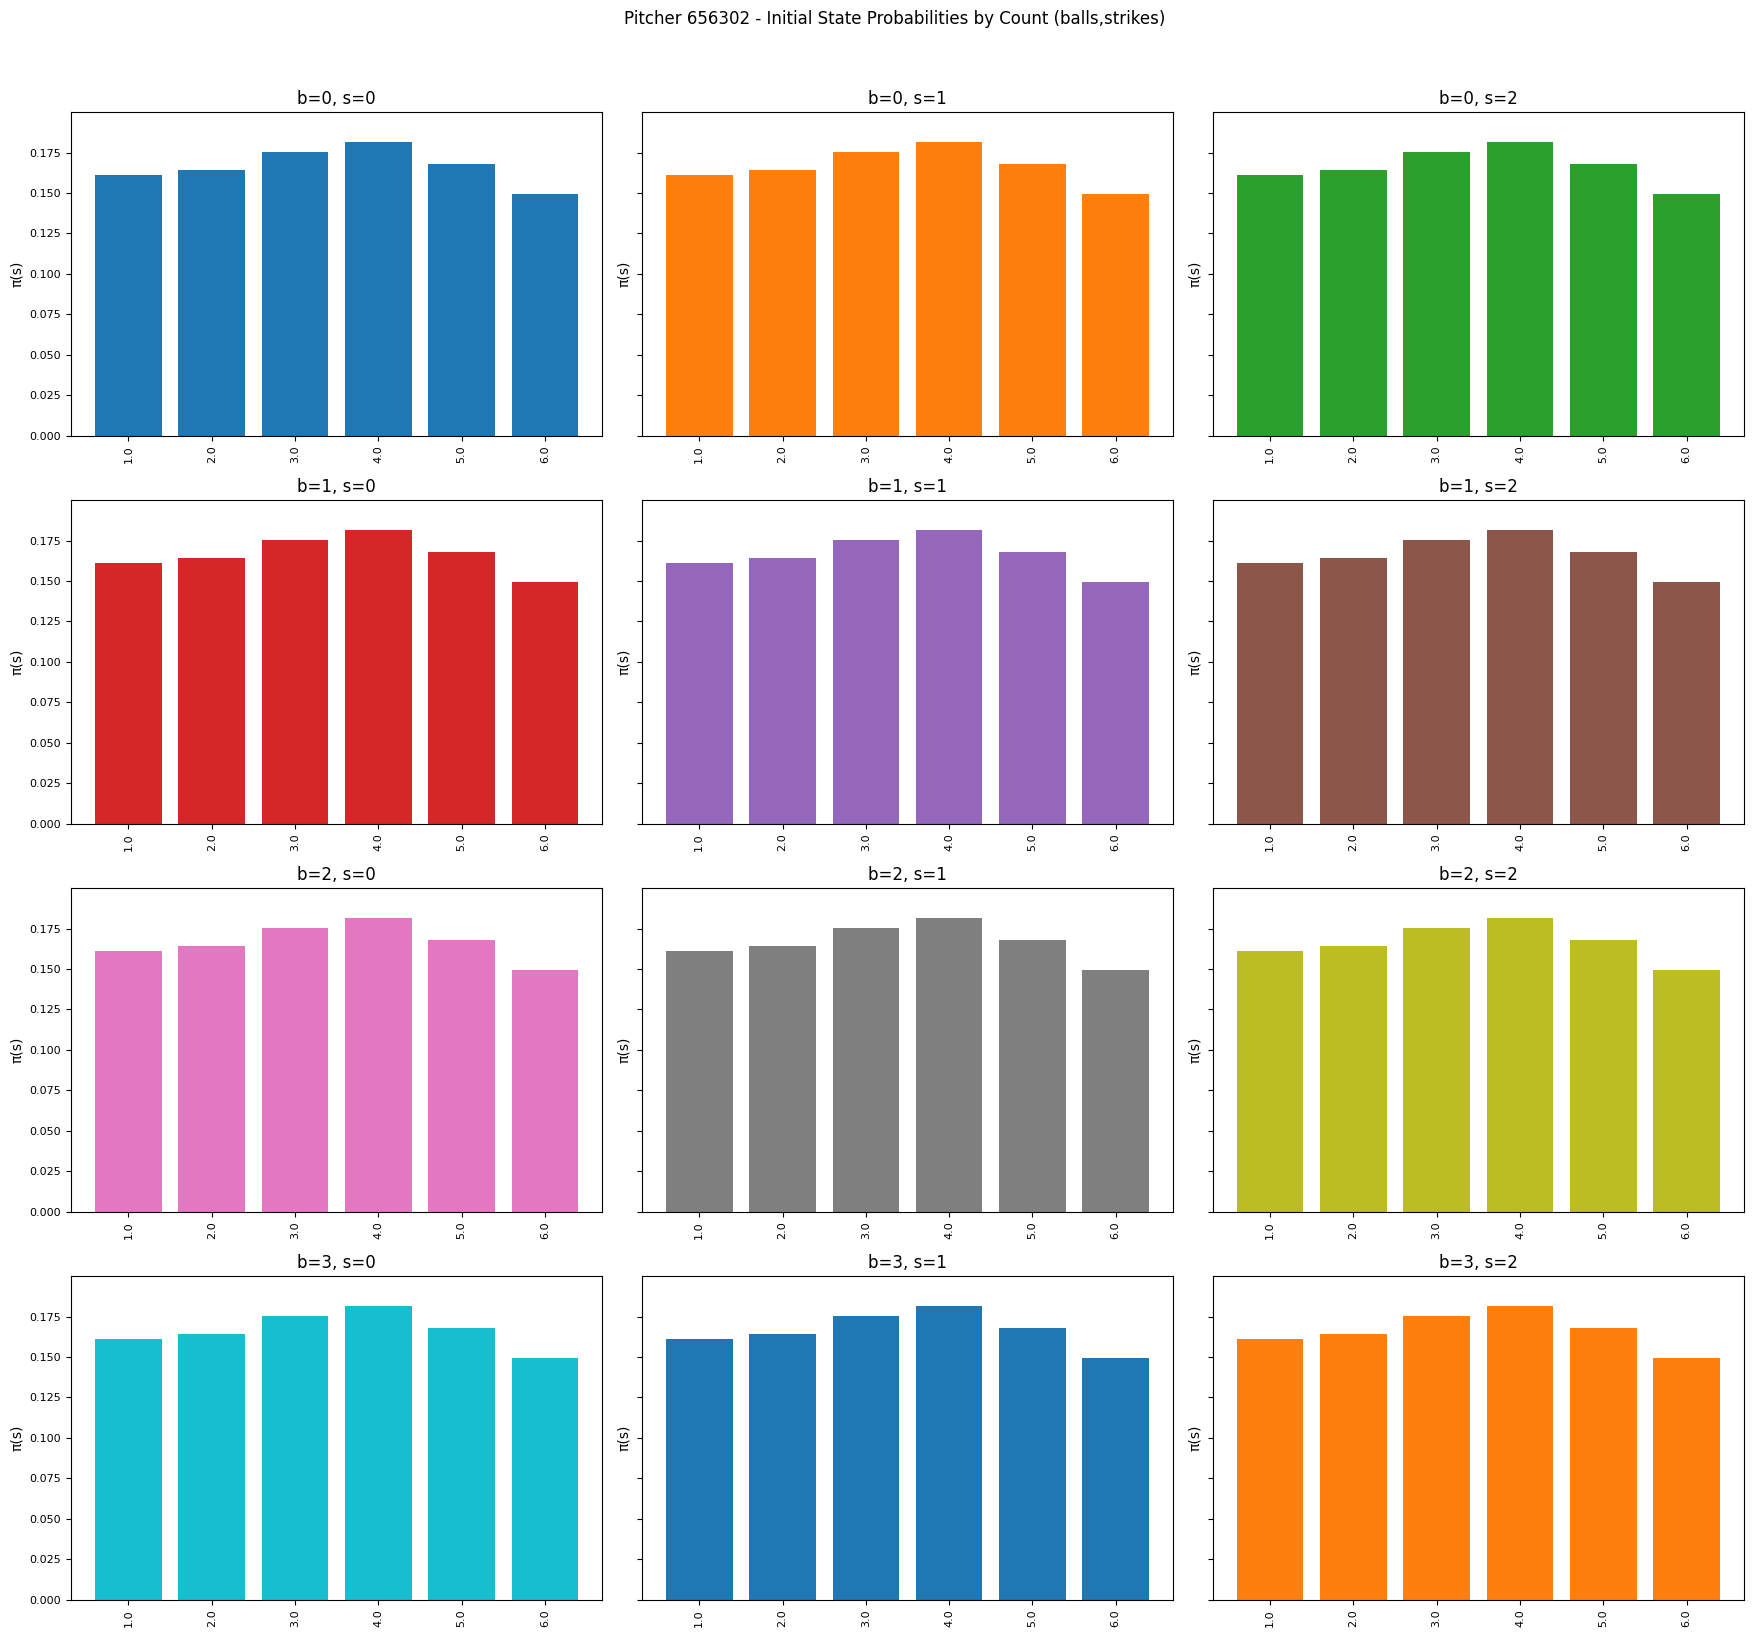

In [10]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from math import ceil

# 投手リスト
pitch_list = ["543037", "554430", "605400", "621244", "656302"]

# covariate 全パターン (balls 0-3, strikes 0-2)
covs = [(b, s) for b in range(4) for s in range(3)]
n_cov = len(covs)
n_cols = 3
n_rows = ceil(n_cov / n_cols)

for pitch in pitch_list:
    model_dir = f"iohmm_{pitch}"
    model_fp  = os.path.join(model_dir, "unsup6_model.pkl")
    enc_fp    = os.path.join(model_dir, "un6_encoders.pkl")

    if not os.path.isfile(model_fp) or not os.path.isfile(enc_fp):
        print(f"[{pitch}] モデルまたはエンコーダが見つかりません。スキップします。")
        continue

    # モデルとエンコーダ読み込み
    with open(model_fp, "rb") as mf:
        shmm_loaded = pickle.load(mf)
    with open(enc_fp, "rb") as ef:
        encs = pickle.load(ef)
    le_z = encs["le_zone"]

    state_ids    = np.arange(shmm_loaded.num_states)
    state_labels = le_z.inverse_transform(state_ids)

    # 図の準備
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows), sharey=True)
    axes = axes.flatten()
    fig.suptitle(f"Pitcher {pitch} - Initial State Probabilities by Count (balls,strikes)", y=1.02)

    for idx, (b, s) in enumerate(covs):
        ax = axes[idx]
        # 初期状態確率 π(s | b, s)
        pi = np.exp(
            shmm_loaded.model_initial
                      .predict_log_proba(np.array([[b, s]]))
        ).flatten()

        x = np.arange(len(state_labels))
        ax.bar(x, pi, color=f"C{idx % 10}")
        ax.set_title(f"b={b}, s={s}", fontsize=12)
        ax.set_xticks(x)
        ax.set_xticklabels(state_labels, rotation=90, fontsize=8)
        ax.set_ylabel("π(s)", fontsize=10)
        ax.set_ylim(0, pi.max() * 1.1)
        ax.yaxis.set_tick_params(labelsize=8)

    # 余った subplot はオフにする
    for j in range(n_cov, n_rows * n_cols):
        axes[j].axis("off")

    plt.tight_layout(rect=[0, 0, 0.98, 1.00])
    plt.show()


In [14]:
# evaluate_iohmm_unsup6.py
# 完全非教師ありモデル（6状態）を評価し、混同行列と精度を保存

import os
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix
from IOHMM import UnSupervisedIOHMM, DiscreteMNL, CrossEntropyMNL

# training 時と同じクラス定義をここに置く
class SmoothedDiscreteMNL(DiscreteMNL):
    def __init__(self, solver='lbfgs', alpha=1.0, **kw):
        super().__init__(solver=solver, **kw)
        self.alpha = alpha
    def predict_log_proba(self, X):
        logp = super().predict_log_proba(X)
        p    = np.exp(logp)
        p += self.alpha
        p /= p.sum(axis=1, keepdims=True)
        return np.log(p)
    def loglike_per_sample(self, X, y):
        y_idx = y.ravel().astype(int)
        lp    = self.predict_log_proba(X)
        return lp[np.arange(len(y_idx)), y_idx]

# 評価する投手リスト
pitch_list = ["543037","554430","605400","621244","656302"]

for pitch in pitch_list:
    dir_name   = f"iohmm_{pitch}"
    model_file = os.path.join(dir_name, 'unsup6_model.pkl')
    test_file  = os.path.join(dir_name, 'un6_test_data.csv')
    enc_file   = os.path.join(dir_name, 'un6_encoders.pkl')

    # ファイルチェック
    if not all(os.path.isfile(p) for p in [model_file, test_file, enc_file]):
        print(f"[{pitch}] 必要ファイルが揃っていません。スキップします。")
        continue

    # モデル＆エンコーダ読み込み
    with open(model_file, 'rb') as mf:
        shmm = pickle.load(mf)
    df_test = pd.read_csv(test_file)
    with open(enc_file, 'rb') as ef:
        encs = pickle.load(ef)
    le_z   = encs['le_zone']
    le_pcl = encs['le_pitch_cluster_label']
    le_zcl = encs['le_zone_cluster']

    # テスト系列だけ取り出し（DataFrame のみ）
    seqs_only = [gdf.reset_index(drop=True)
                  for _, gdf in df_test.groupby('game_pk')]

    # モデルにセットして後分布を計算
    shmm.set_data(seqs_only)
    shmm.E_step()

    # 最尤パスを取得
    posterior_paths = [np.argmax(logg, axis=1) for logg in shmm.log_gammas]

    # 真ラベル・予測値リスト
    hidden_true, hidden_pred = [], []
    true_p, pred_p = [], []
    true_z, pred_z = [], []

    # 系列ごとに集計
    for (df_seq), path in zip(seqs_only, posterior_paths):
        # hidden state
        hidden_true.extend(df_seq['zone'].astype(int).values)
        hidden_pred.extend(path)

        # emission
        X = df_seq[['balls','strikes']].values
        true_p .append(df_seq['pitch_cluster_label'].values)
        true_z .append(df_seq['zone_cluster'].values)

        pp, pz = [], []
        for t, s in enumerate(path):
            logp0 = shmm.model_emissions[s][0].predict_log_proba(X[t].reshape(1,-1))
            pp.append(int(np.argmax(np.exp(logp0))))
            logp1 = shmm.model_emissions[s][1].predict_log_proba(X[t].reshape(1,-1))
            pz.append(int(np.argmax(np.exp(logp1))))
        pred_p.append(np.array(pp))
        pred_z.append(np.array(pz))

    # 平坦化
    hidden_true = np.array(hidden_true)
    hidden_pred = np.array(hidden_pred)
    y_true_p = np.hstack(true_p); y_pred_p = np.hstack(pred_p)
    y_true_z = np.hstack(true_z); y_pred_z = np.hstack(pred_z)

    # 精度
    acc_h = accuracy_score(hidden_true, hidden_pred)
    acc_p = accuracy_score(y_true_p,   y_pred_p)
    acc_z = accuracy_score(y_true_z,   y_pred_z)
    print(f"[{pitch}] Hidden acc: {acc_h:.4f}, Pitch-cluster acc: {acc_p:.4f}, Zone-cluster acc: {acc_z:.4f}")

    # 混同行列
    cm_h = confusion_matrix(hidden_true, hidden_pred)
    cm_p = confusion_matrix(y_true_p,   y_pred_p)
    cm_z = confusion_matrix(y_true_z,   y_pred_z)

    df_cm_h = pd.DataFrame(cm_h, index=le_z.classes_,    columns=le_z.classes_)
    df_cm_p = pd.DataFrame(cm_p, index=le_pcl.classes_, columns=le_pcl.classes_)
    df_cm_z = pd.DataFrame(cm_z, index=le_zcl.classes_, columns=le_zcl.classes_)

    # 保存
    df_cm_h.to_csv(os.path.join(dir_name, 'un6_cm_hidden.csv'))
    df_cm_p.to_csv(os.path.join(dir_name, 'un6_cm_pitch_cluster.csv'))
    df_cm_z.to_csv(os.path.join(dir_name, 'un6_cm_zone_cluster.csv'))
    with open(os.path.join(dir_name, 'un6_evaluation_accuracy.txt'), 'w') as outf:
        outf.write(f"hidden_state_accuracy:      {acc_h:.4f}\n")
        outf.write(f"pitch_cluster_accuracy:     {acc_p:.4f}\n")
        outf.write(f"zone_cluster_accuracy:      {acc_z:.4f}\n")

    print(f"[{pitch}] 評価結果を保存しました\n")


[543037] Hidden acc: 0.0567, Pitch-cluster acc: 0.5170, Zone-cluster acc: 0.2625
[543037] 評価結果を保存しました

[554430] Hidden acc: 0.0641, Pitch-cluster acc: 0.6375, Zone-cluster acc: 0.2802
[554430] 評価結果を保存しました

[605400] Hidden acc: 0.0435, Pitch-cluster acc: 0.4932, Zone-cluster acc: 0.3061
[605400] 評価結果を保存しました

[621244] Hidden acc: 0.0507, Pitch-cluster acc: 0.5455, Zone-cluster acc: 0.3004
[621244] 評価結果を保存しました

[656302] Hidden acc: 0.0447, Pitch-cluster acc: 0.4285, Zone-cluster acc: 0.3235
[656302] 評価結果を保存しました



In [12]:
import matplotlib.font_manager as fm

# 日本語対応フォント候補を抽出して表示
for font in fm.findSystemFonts(fontpaths=None, fontext='ttf'):
    if any(x in font.lower() for x in ['gothic', 'meiryo', 'noto', 'ipa', 'takao']):
        print(font)


/usr/share/fonts/opentype/noto/NotoSerifCJK-Bold.ttc
/usr/share/fonts/opentype/noto/NotoSansCJK-Light.ttc
/usr/share/fonts/meiryo/meiryo.ttc
/usr/share/fonts/opentype/ipafont-gothic/ipagp.ttf
/usr/share/fonts/opentype/urw-base35/URWGothic-Demi.otf
/usr/share/fonts/truetype/fonts-japanese-gothic.ttf
/usr/share/fonts/opentype/ipafont-gothic/ipag.ttf
/usr/share/fonts/truetype/takao-mincho/TakaoMincho.ttf
/usr/share/fonts/opentype/noto/NotoSansCJK-Bold.ttc
/usr/share/fonts/truetype/noto/NotoSansMono-Regular.ttf
/usr/share/fonts/opentype/noto/NotoSansCJK-Black.ttc
/usr/share/fonts/opentype/urw-base35/URWGothic-Book.otf
/usr/share/fonts/opentype/noto/NotoSerifCJK-Medium.ttc
/usr/share/fonts/opentype/noto/NotoSansCJK-Medium.ttc
/usr/share/fonts/truetype/takao-gothic/TakaoGothic.ttf
/usr/share/fonts/truetype/takao-mincho/TakaoPMincho.ttf
/usr/share/fonts/opentype/ipafont-mincho/ipam.ttf
/usr/share/fonts/opentype/noto/NotoSerifCJK-Light.ttc
/usr/share/fonts/meiryo/meiryob.ttc
/usr/share/fonts/t

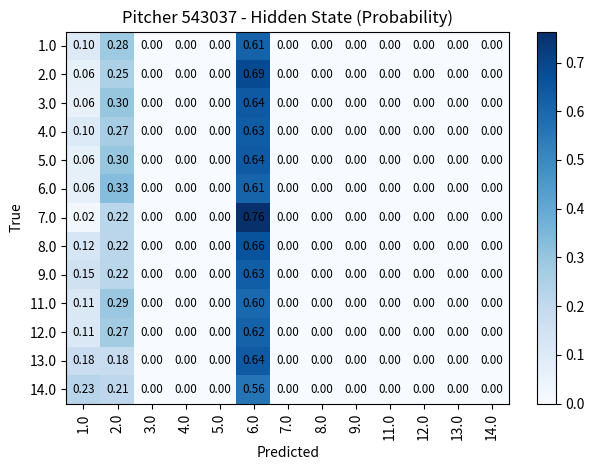

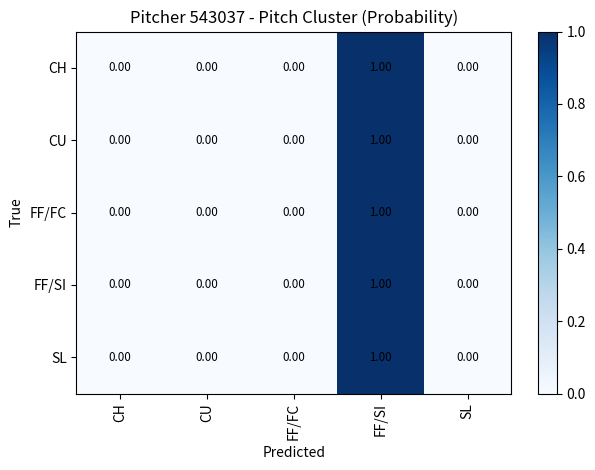

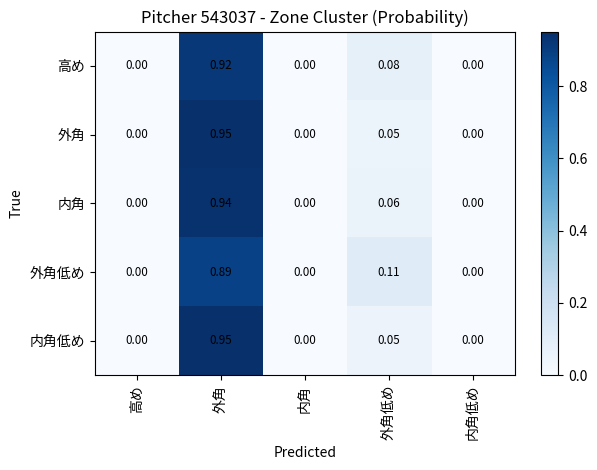

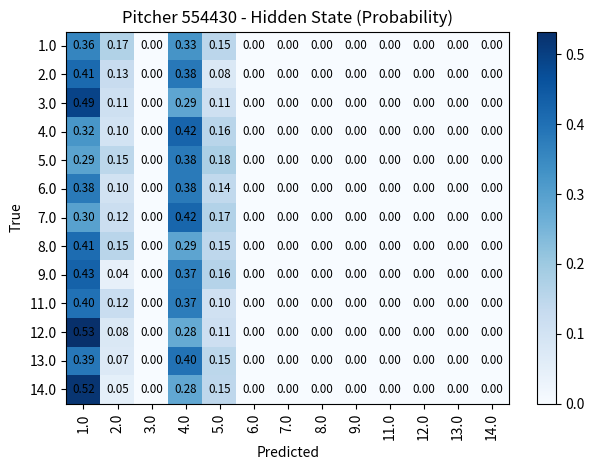

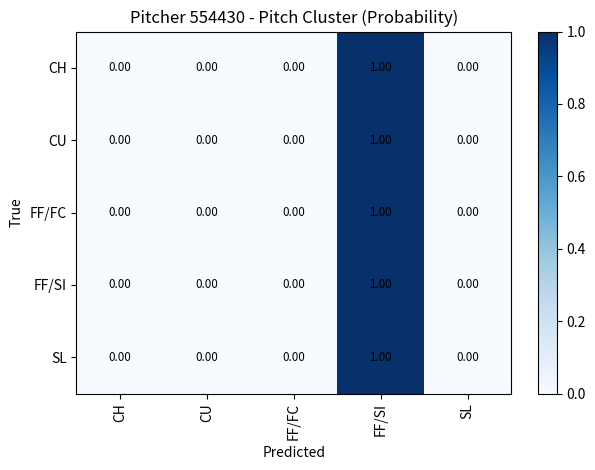

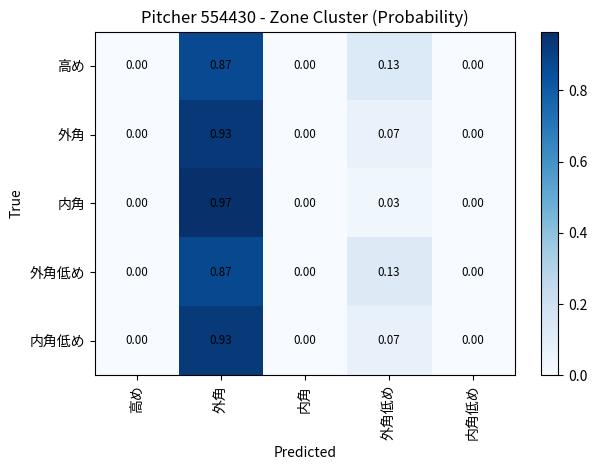

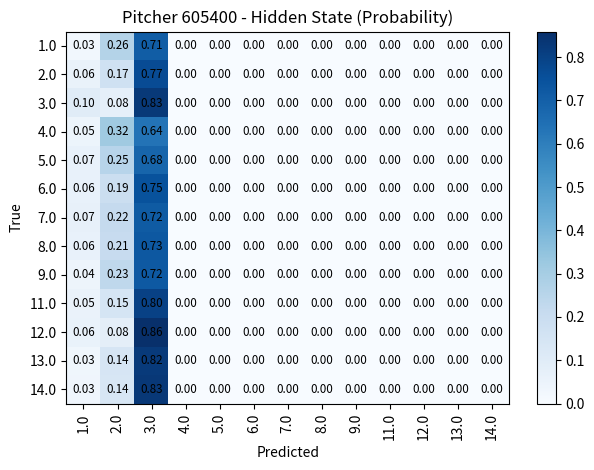

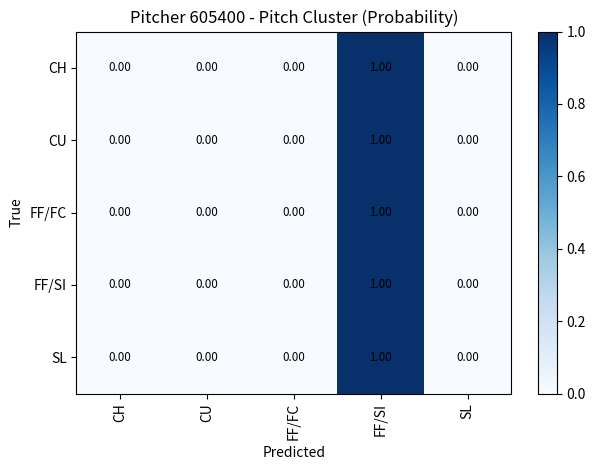

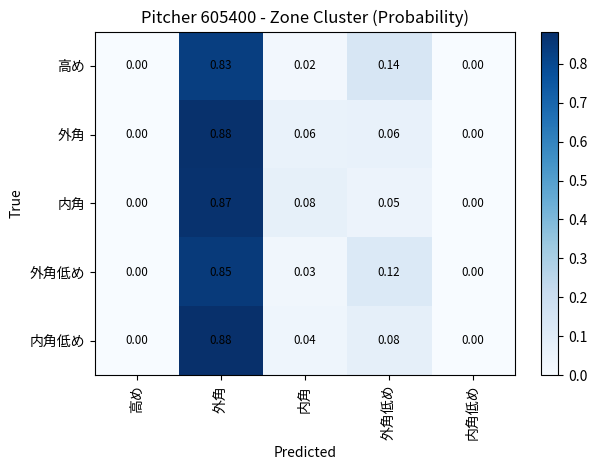

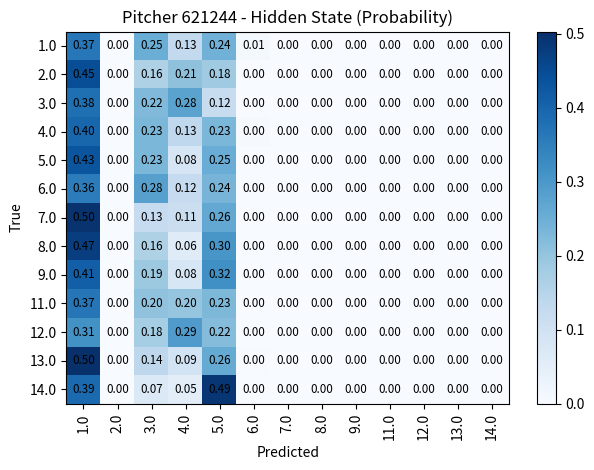

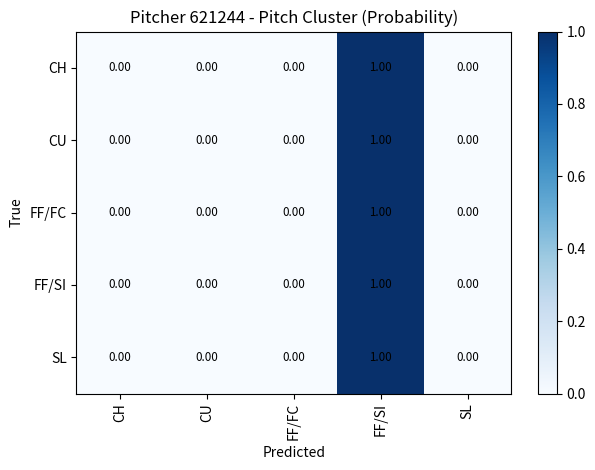

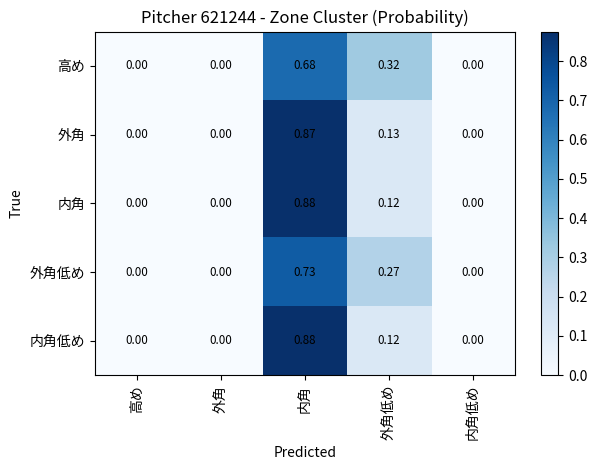

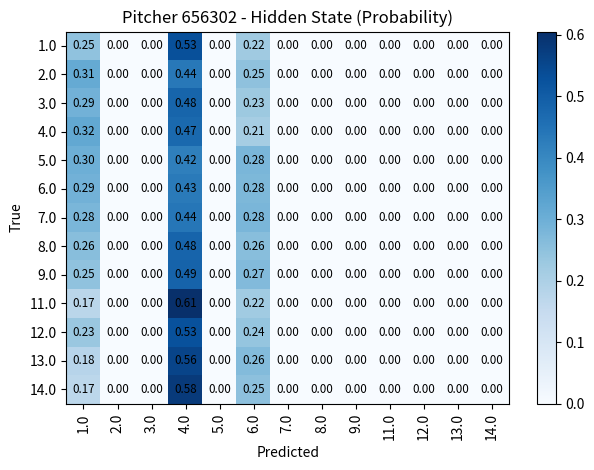

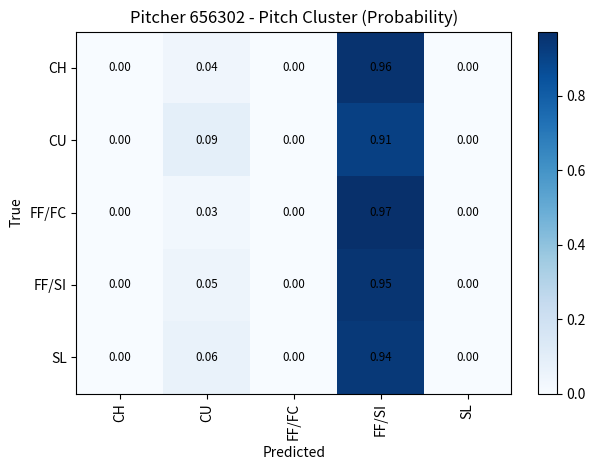

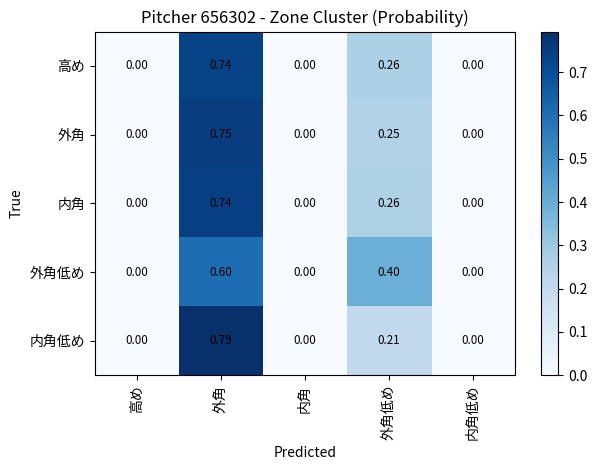

In [15]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.font_manager import FontProperties

# Zone Cluster 用の日本語マッピング
zone_names = {
    0: "高め",
    1: "外角",
    2: "内角",
    3: "外角低め",
    4: "内角低め"
}

pitch_list = ["543037", "554430", "605400", "621244", "656302"]
matrix_files = {
    "Hidden State":    "un6_cm_hidden.csv",
    "Pitch Cluster":   "un6_cm_pitch_cluster.csv",
    "Zone Cluster":    "un6_cm_zone_cluster.csv"
}

for pitch in pitch_list:
    dir_name = f"iohmm_{pitch}"
    for title, filename in matrix_files.items():
        path = os.path.join(dir_name, filename)
        if not os.path.exists(path):
            continue

        df_cm   = pd.read_csv(path, index_col=0)
        df_prop = df_cm.div(df_cm.sum(axis=1), axis=0).fillna(0)

        fig, ax = plt.subplots()
        im = ax.imshow(df_prop.values, aspect='auto', cmap='Blues')
        plt.colorbar(im, ax=ax)

        # タイトルに応じて軸ラベルを切り替え
        if title == "Zone Cluster":
            # Zone のときのみ日本語ラベル
            x_labels = [zone_names[int(c)] for c in df_prop.columns]
            y_labels = [zone_names[int(c)] for c in df_prop.index]
        else:
            # それ以外は数字のまま
            x_labels = [str(c) for c in df_prop.columns]
            y_labels = [str(c) for c in df_prop.index]

        # Noto Sans CJK を指定
        jp_font = FontProperties(fname='/usr/share/fonts/opentype/noto/NotoSansCJK-DemiLight.ttc')

        # 日本語フォント設定
        rcParams['font.family'] = jp_font.get_name()
        rcParams['axes.unicode_minus'] = False  # マイナス記号の文字化け対策
        ax.set_xticks(range(len(x_labels)))
        ax.set_xticklabels(x_labels, rotation=90)
        ax.set_yticks(range(len(y_labels)))
        ax.set_yticklabels(y_labels)

        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")
        ax.set_title(f"Pitcher {pitch} - {title} (Probability)")

        # 数値注記
        for i in range(df_prop.shape[0]):
            for j in range(df_prop.shape[1]):
                ax.text(j, i, f"{df_prop.iat[i,j]:.2f}",
                        ha="center", va="center", fontsize='small', color='black')

        plt.tight_layout()
        plt.show()


In [3]:
    # 全体データ読み込み
df_all = pd.read_csv('df_clean_zone_cluster.csv')
 # 投球数上位5投手を抽出
top5 = df_all['pitcher'].value_counts().nlargest(5).index.tolist()
print(f"Top5 pitchers: {top5}")

Top5 pitchers: [605400, 554430, 656302, 543037, 621244]


In [6]:
!pip install ace_tools

Defaulting to user installation because normal site-packages is not writeable


In [9]:
import pandas as pd
from IPython.display import display

# 上位5投手を抽出
top5 = df_all['pitcher'].value_counts().nlargest(5).index.tolist()
df_top5 = df_all[df_all['pitcher'].isin(top5)]

# 1) 球種クラスタ分布（カウント）
dist_pcl = (
    df_top5
    .groupby(['pitcher', 'pitch_cluster_label'])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)
print("Pitch Cluster Distribution (counts)")
display(dist_pcl)

# 2) ゾーンクラスタ分布（カウント）
dist_zcl = (
    df_top5
    .groupby(['pitcher', 'zone_cluster'])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)
print("Zone Cluster Distribution (counts)")
display(dist_zcl)

# 3) 球種クラスタ分布（割合）
dist_pcl_prop = dist_pcl.div(dist_pcl.sum(axis=1), axis=0).round(3)
print("Pitch Cluster Distribution (proportion)")
display(dist_pcl_prop)

# 4) ゾーンクラスタ分布（割合）
dist_zcl_prop = dist_zcl.div(dist_zcl.sum(axis=1), axis=0).round(3)
print("Zone Cluster Distribution (proportion)")
display(dist_zcl_prop)

Pitch Cluster Distribution (counts)


pitch_cluster_label,CH,CU,FF/FC,FF/SI,SL
pitcher,,,,,
543037,1036,2079,432,7254,3068
554430,456,1832,666,9015,2340
605400,2376,4356,11,7266,875
621244,2152,3299,46,7123,704
656302,580,3586,177,5939,3661


Zone Cluster Distribution (counts)


zone_cluster,0,1,2,3,4
pitcher,,,,,
543037,2326,3981,2966,2725,1871
554430,2243,4213,3507,2043,2303
605400,1745,4312,2949,2569,3309
621244,1098,3122,3906,2254,2944
656302,3008,4310,1740,3203,1682


Pitch Cluster Distribution (proportion)


pitch_cluster_label,CH,CU,FF/FC,FF/SI,SL
pitcher,,,,,
543037,0.075,0.150,0.031,0.523,0.221
554430,0.032,0.128,0.047,0.630,0.164
605400,0.160,0.293,0.001,0.488,0.059
621244,0.162,0.248,0.003,0.535,0.053
656302,0.042,0.257,0.013,0.426,0.263


Zone Cluster Distribution (proportion)


zone_cluster,0,1,2,3,4
pitcher,,,,,
543037,0.168,0.287,0.214,0.196,0.135
554430,0.157,0.294,0.245,0.143,0.161
605400,0.117,0.290,0.198,0.173,0.222
621244,0.082,0.234,0.293,0.169,0.221
656302,0.216,0.309,0.125,0.230,0.121


In [17]:
import os
import pickle
import numpy as np
import pandas as pd
from IPython.display import display

# ---- ここを適宜変更 ----
pitch    = "543037"
model_fp = os.path.join(f"iohmm_{pitch}", "semi_model.pkl")
# ------------------------

# モデル読み込み
with open(model_fp, "rb") as f:
    shmm = pickle.load(f)

# 状態数
K = shmm.num_states

# 1) 初期状態確率 P(h0 = s | x0)
# x0_mean: 全系列・全時点の initial covariate をまとめた inp_initials_all_sequences から平均
X0_all   = np.vstack(shmm.inp_initials_all_sequences)   # shape (N, d0)
x0_mean  = X0_all.mean(axis=0).reshape(1, -1)           # shape (1, d0)
# model_initial は CrossEntropyMNL
logpi    = shmm.model_initial.predict_log_proba(x0_mean)  # (1, K)
pi       = np.exp(logpi).ravel()                          # (K,)

df_pi = pd.DataFrame(pi.reshape(1, -1), columns=[f"state_{i}" for i in range(K)])
print("Initial state probabilities (at mean initial covariate):")
display(df_pi)

# 2) 遷移確率 P(h_{t+1}=j | h_t=i, x_trans)
# x_trans_mean: 全系列・全時点の transition covariate をまとめた inp_transitions_all_sequences から平均
X1_all    = np.vstack(shmm.inp_transitions_all_sequences)  # shape (M, d1)
x1_mean   = X1_all.mean(axis=0).reshape(1, -1)            # shape (1, d1)
# 各状態 i→の遷移モデルを呼び出し
trans_mat = np.zeros((K, K))
for i, clf in enumerate(shmm.model_transition):
    # predict_log_proba → log 確率
    logp = clf.predict_log_proba(x1_mean)   # (1, K)
    trans_mat[i] = np.exp(logp).ravel()

df_trans = pd.DataFrame(
    trans_mat,
    index=[f"from_{i}" for i in range(K)],
    columns=[f"to_{j}"   for j in range(K)]
)
print("Transition probabilities (at mean transition covariate):")
display(df_trans)

# 3) Emission 確率 P(y | h=s, x_em)
# それぞれの emission モデル群について
for e_idx, em_models in enumerate(shmm.model_emissions):
    # 全系列・全時点の e_idx 番目の emission covariate をまとめて平均
    Xem_all = np.vstack(shmm.inp_emissions_all_sequences[e_idx])  # shape (L, d_em)
    xem_mean = Xem_all.mean(axis=0).reshape(1, -1)

    # それぞれの隠れ状態 s での出力確率分布を取る
    emis_mat = np.zeros((K, shmm.model_emissions[e_idx][0].n_classes_))
    for s in range(K):
        logp_ed = em_models[s].predict_log_proba(xem_mean)  # (1, C)
        emis_mat[s] = np.exp(logp_ed).ravel()

    # DataFrame 化
    cls_names = [
        f"{col}" 
        for col in shmm.responses_emissions[e_idx]
    ]
    df_emis = pd.DataFrame(
        emis_mat,
        index=[f"state_{s}" for s in range(K)],
        columns=[str(c) for c in range(emis_mat.shape[1])]
    )
    title = ["Pitch Cluster", "Zone Cluster"][e_idx]
    print(f"Emission probabilities for {title} (at mean covariate):")
    display(df_emis)


Initial state probabilities (at mean initial covariate):


,state_0,state_1,state_2,state_3,state_4,state_5,state_6,state_7,state_8,state_9,state_10,state_11,state_12
0,0.081138,0.090077,0.027055,0.09912,0.090138,0.081114,0.045098,0.063127,0.035938,0.10809,0.117124,0.045069,0.116911


Transition probabilities (at mean transition covariate):


,to_0,to_1,to_2,to_3,to_4,to_5,to_6,to_7,to_8,to_9,to_10,to_11,to_12
from_0,0.058615,0.073323,0.036945,0.056054,0.079269,0.065979,0.026184,0.054098,0.049458,0.149954,0.096240,0.051843,0.202037
from_1,0.048307,0.064111,0.044125,0.043799,0.102886,0.066050,0.026713,0.057142,0.051126,0.136030,0.076306,0.058182,0.225223
from_2,0.071974,0.071357,0.036229,0.044160,0.097547,0.081030,0.025979,0.053185,0.050230,0.135536,0.061626,0.054676,0.216471
from_3,0.052299,0.071203,0.037731,0.075037,0.072930,0.065264,0.049928,0.056603,0.054284,0.128977,0.062696,0.057903,0.215145
from_4,0.054975,0.087834,0.042566,0.043915,0.083799,0.070454,0.031284,0.045984,0.054840,0.126860,0.061423,0.066170,0.229895
from_5,0.058998,0.058578,0.037004,0.057454,0.084132,0.065921,0.027067,0.054327,0.077065,0.144816,0.070172,0.047324,0.217140
from_6,0.049687,0.058830,0.039184,0.045893,0.087634,0.065757,0.029481,0.063089,0.054234,0.162999,0.071789,0.064824,0.206600
from_7,0.057065,0.084966,0.043588,0.060224,0.076485,0.080658,0.026691,0.045438,0.049932,0.164393,0.060826,0.048697,0.201037
from_8,0.045429,0.071890,0.041811,0.039643,0.088701,0.065081,0.030712,0.056208,0.071266,0.153320,0.071002,0.043547,0.221390
from_9,0.071303,0.057694,0.040617,0.059614,0.076772,0.067948,0.033111,0.052642,0.057655,0.139929,0.066729,0.057529,0.218457


AttributeError: 'SmoothedDiscreteMNL' object has no attribute 'n_classes_'

In [26]:
import pandas as pd

# CSV読み込み
df = pd.read_csv('df_clean_zone_cluster.csv')

# 投手ID→名前のマッピングがあれば取得
# （CSVに 'pitcher_name' 列がある場合）
if 'player_name' in df.columns:
    pitcher_map = (
        df[['pitcher','player_name']]
        .drop_duplicates()
        .set_index('pitcher')['player_name']
    )
else:
    pitcher_map = None

# 上位5投手リスト（例）
pitch_list = [543037,554430,605400,621244,656302]

# 結果を格納するリスト
results = []

for pid in pitch_list:
    df_p = df[df['pitcher'] == pid]
    total_pitches = len(df_p)                     # 投球数
    total_games   = df_p['game_pk'].nunique()      # 試合数
    name = pitcher_map[pid] if pitcher_map is not None else pid
    results.append({
        'pitcher_id': pid,
        'pitcher_name': name,
        'total_pitches': total_pitches,
        'total_games': total_games
    })

# DataFrame化して表示
res_df = pd.DataFrame(results)
res_df = res_df.sort_values('total_pitches', ascending=False).reset_index(drop=True)

print(res_df)


   pitcher_id   pitcher_name  total_pitches  total_games
0      605400    Nola, Aaron          14884          161
1      554430  Wheeler, Zack          14309          151
2      656302   Cease, Dylan          13943          148
3      543037   Cole, Gerrit          13869          144
4      621244  Berríos, José          13324          149


In [20]:
df_pi.head()

,Unnamed: 0,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,...,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,original_index,pitch_cluster_label,cluster,zone_cluster,strike
0,0,FF,2020-07-23,95.3,-3.28,5.47,"Scherzer, Max",543305,453286,NaN,...,2.0,1.26,0.86,-0.86,24.9,17,FF/SI,2,2,0
1,1,FF,2020-07-23,96.1,-3.38,5.33,"Scherzer, Max",543305,453286,NaN,...,2.0,1.02,0.79,-0.79,21.8,18,FF/SI,2,2,0
2,2,FF,2020-07-23,96.7,-3.21,5.33,"Scherzer, Max",543305,453286,NaN,...,2.0,1.17,0.78,-0.78,23.6,19,FF/SI,1,1,1
3,3,CU,2020-07-23,79.7,-3.36,5.48,"Scherzer, Max",543305,453286,NaN,...,2.0,4.41,-0.95,0.95,26.7,20,CU,4,4,1
4,4,FF,2020-07-23,96.1,-3.28,5.13,"Scherzer, Max",543305,453286,field_out,...,2.0,1.22,0.75,-0.75,18.1,21,FF/SI,2,2,1
